## Harnessing Data and Statistical Insights to Drive Innovation and Sustainability in Irish Agriculture.

## Datasets used 

- FAO data was obtained from https://www.fao.org/faostat/en/#data/TM , multiple datasets were obtained, cleaned and then merged into one final dataset called df 

- Sentiment data wasobtaiend from an API usign reddits PRAW and saved as reddit_df

This Jupiter Notebook is broken down in sections. Each section has a brief explanation of the process it undergoes as well as the rationale for the strategies used.
The comments in the code are used to understand the researchers logic and method of choice. 
Descriptive statistics and data profiling were performed to give the researcher an idea of the structure and the basic statistics of the dataset.

Once the structure was determined, each dataset was cleaned and modified using various dataset modification techiniques. The goal of the dataset manipulation was to prepare the datasets for the merging step where they are merged into one new dataset using the common "Datetime" column.

After merging the dataset, the researcher performed EDA on the merged dataset. They also use graphs to show the trends and relationships of the columns. The merged dataset was saved to CSV file called "df.csv" which was used in the Machine Learning.

In [67]:
# Importing libraries for NLP and data preprocessing
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import praw
import requests
import datetime as dt
# Importing libraries for NLP and data preprocessing
import nltk 
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')
from wordcloud import WordCloud
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Gathering Reddit Data for Sentiment Analysis 

In [68]:
def fetch_reddit_comments(client_id, client_secret, user_agent, subreddit_name, search_title, comment_limit=2):
    """
    Fetch comments from a specific Reddit post in a given subreddit based on the title.
    
    Parameters:
        client_id (str): Reddit API client ID.
        client_secret (str): Reddit API client secret.
        user_agent (str): Reddit API user agent.
        subreddit_name (str): Subreddit to search in.
        search_title (str): Title of the post to search for.
        comment_limit (int): Limit for expanding 'more comments' (default is 2).
    
    Returns:
        pd.DataFrame: A DataFrame containing comments and their scores.
    """
    # Set up PRAW with the provided credentials
    reddit = praw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        user_agent=user_agent
    )

    # Initialize an empty list to store comment data
    comments_data = []

    try:
        # Perform the search within the specified subreddit
        for submission in reddit.subreddit(subreddit_name).search(search_title, syntax='lucene'):
            if submission.title.strip().lower() == search_title.strip().lower():  # Ensure exact title match
                print(f"Found Post: {submission.title}")
                
                # Fetch comments for the found post
                submission.comments.replace_more(limit=comment_limit)  # Avoid 'More Comments' issue
                comments = submission.comments.list()

                # Loop through each comment and store relevant data
                for comment in comments:
                    comment_data = {
                        "score": comment.score,
                        "body": comment.body,
                    }
                    comments_data.append(comment_data)
                break  # Exit loop after processing the correct post

    except Exception as e:
        print(f"Error fetching comments: {e}")

    # Convert the list of comments data to a DataFrame
    df = pd.DataFrame(comments_data)
    return df



In [69]:
#Calling the function
df_reddit = fetch_reddit_comments(
    client_id="Eh0bl10lZEOwhtx0aZ5ocA",
    client_secret="y0vCwJ-OCmMxgvSJtFDXRZ9RaE4dtg",
    user_agent="Scraper 1.0 /u/Big_Brilliant_9638",
    subreddit_name="Ireland",
    search_title="Ireland has one of the lowest rates of food price inflation in the world. More good news.",
    comment_limit=20
)

# Display the DataFrame
print(df_reddit.shape)
df_reddit.head()


Found Post: Ireland has one of the lowest rates of food price inflation in the world. More good news.
(401, 2)


,score,body
0,559,Ireland has always done food well. Excellent q...
1,217,Food is genuinely super cheap in Ireland relat...
2,57,As a Polish person I can confirm that. I visit...
3,42,"Poor, poor Turkey.\n\nAnd damn, the Swiss are ..."
4,105,The quality and price of fruit and veg and sta...


## Cleaning preprocessing, and feature engineering the reddit posts 

In [70]:
# Initialise containers and Vader sentiment
sia = SIA()
results = []
# Perform sentiment analysis on each comment
for index, row in df_reddit.iterrows():
    comment_text = row['body']
    # Get sentiment polarity score
    pol_score = sia.polarity_scores(comment_text)
    # Add the sentiment scores to the results list
    results.append(pol_score)

# Add sentiment results to the DataFrame
df_reddit[['neg', 'neu', 'pos', 'compound']] = pd.DataFrame(results)

# Display the DataFrame with sentiment analysis results
df_reddit.head()

,score,body,neg,neu,pos,compound
0,559,Ireland has always done food well. Excellent q...,0.000,0.580,0.420,0.7003
1,217,Food is genuinely super cheap in Ireland relat...,0.035,0.836,0.128,0.8259
2,57,As a Polish person I can confirm that. I visit...,0.000,1.000,0.000,0.0000
3,42,"Poor, poor Turkey.\n\nAnd damn, the Swiss are ...",0.535,0.465,0.000,-0.8478
4,105,The quality and price of fruit and veg and sta...,0.000,0.756,0.244,0.7960


In [71]:
#Define sentiment labels
def label_sentiment(compound_score):
    if compound_score >= 0.05:
        return "Positive"
    elif compound_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

#Creating  a new sentiment label column for machine learning 
df_reddit['sentiment_label'] = df_reddit['compound'].apply(label_sentiment)
df_reddit.dropna(inplace=True)
df_reddit.head()

,score,body,neg,neu,pos,compound,sentiment_label
0,559,Ireland has always done food well. Excellent q...,0.000,0.580,0.420,0.7003,Positive
1,217,Food is genuinely super cheap in Ireland relat...,0.035,0.836,0.128,0.8259,Positive
2,57,As a Polish person I can confirm that. I visit...,0.000,1.000,0.000,0.0000,Neutral
3,42,"Poor, poor Turkey.\n\nAnd damn, the Swiss are ...",0.535,0.465,0.000,-0.8478,Negative
4,105,The quality and price of fruit and veg and sta...,0.000,0.756,0.244,0.7960,Positive


In [72]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    try:
        # Convert text to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)      
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#', '', text)
        # Remove special characters
        text = re.sub(r'[^A-Za-z\s]', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Lemmatize and remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error in preprocessing text: {e}")
        return None

# Applying preprocessing to a DataFrame
df_reddit['body'] = df_reddit['body'].apply(preprocess_text)
df_reddit.head()

,score,body,neg,neu,pos,compound,sentiment_label
0,559,ireland always done food well excellent qualit...,0.000,0.580,0.420,0.7003,Positive
1,217,food genuinely super cheap ireland relative wa...,0.035,0.836,0.128,0.8259,Positive
2,57,polish person confirm visited poland summer pr...,0.000,1.000,0.000,0.0000,Neutral
3,42,poor poor turkey damn swiss something right,0.535,0.465,0.000,-0.8478,Negative
4,105,quality price fruit veg staple aldi lidl tesco...,0.000,0.756,0.244,0.7960,Positive


## Visualisations for NLP

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


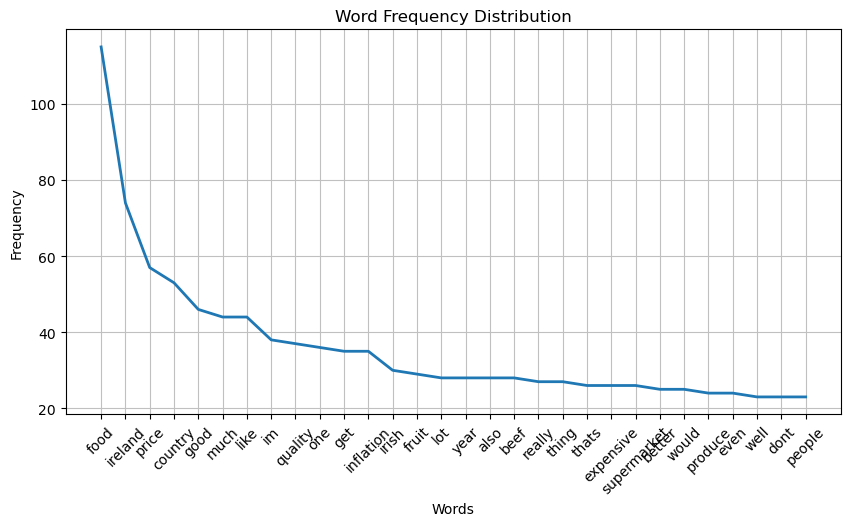

In [73]:
# Downloading NLTK tokenizer
nltk.download('punkt')

# Tokenize each row in the 'body' column
df_reddit['tokens'] = df_reddit['body'].apply(nltk.word_tokenize)

# Flatten the token lists
all_tokens = [token for tokens_list in df_reddit['tokens'] for token in tokens_list]

# Calculate word frequency
freq_dist = FreqDist(all_tokens)

# Plot the most common words
plt.figure(figsize=(10, 5))
freq_dist.plot(30, cumulative=False)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Word Frequency Distribution')
plt.show()


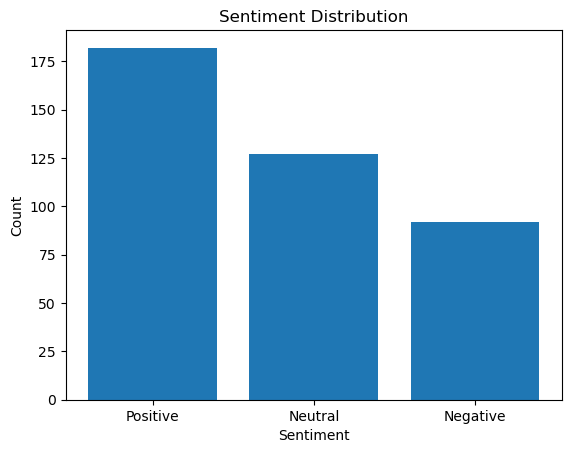

In [74]:
# Creating a plot of the counts of each type of sentiment in the from of positive, neutral and negative 
sentiment_counts = df_reddit['sentiment_label'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title("Sentiment Distribution")
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

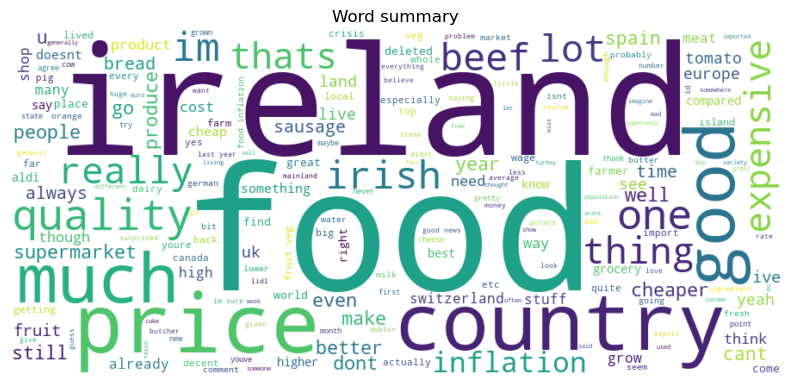

In [75]:
#pip install wordcloud
#Creating a word cloud of the msot frequent words in the reddit post
text = " ".join(df_reddit['body'].dropna())
wordcloud = WordCloud(width = 900, height= 400, background_color="white").generate(text)

#Creating the figure 
plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation="bilinear")
plt.title("Word summary ")
plt.axis("off")
plt.show()

In [76]:
# Saving the cleaned data as a csv file 
df_reddit.to_csv("df_reddit.csv")

In [77]:
df_reddit.head()

,score,body,neg,neu,pos,compound,sentiment_label,tokens
0,559,ireland always done food well excellent qualit...,0.000,0.580,0.420,0.7003,Positive,"[ireland, always, done, food, well, excellent,..."
1,217,food genuinely super cheap ireland relative wa...,0.035,0.836,0.128,0.8259,Positive,"[food, genuinely, super, cheap, ireland, relat..."
2,57,polish person confirm visited poland summer pr...,0.000,1.000,0.000,0.0000,Neutral,"[polish, person, confirm, visited, poland, sum..."
3,42,poor poor turkey damn swiss something right,0.535,0.465,0.000,-0.8478,Negative,"[poor, poor, turkey, damn, swiss, something, r..."
4,105,quality price fruit veg staple aldi lidl tesco...,0.000,0.756,0.244,0.7960,Positive,"[quality, price, fruit, veg, staple, aldi, lid..."


## Gathering numerical data for the EU from 2000-2021

## Reading in and EDA on the first dataset

In [78]:
# Gathering precipitation data for the period 2000-2021 for hte EU 
try:
    # Fetch the data
    df_rain = pd.read_csv("https://ourworldindata.org/grapher/average-precipitation-per-year.csv?v=1&csvType=filtered&useColumnShortNames=true&tab=chart&time=2000..2021&showSelectionOnlyInTable=1&country=ESP~IRL~AUT~HRV~CYP~CZE~DNK~EST~FIN~FRA~DEU~GRC~HUN~ITA~LVA~LTU~LUX~NLD~POL~PRT~ROU~SVK~SVN~SWE~BEL~BGR", storage_options={'User-Agent': 'Our World In Data data fetch/1.0'})

    # Fetch the metadata
    metadata = requests.get("https://ourworldindata.org/grapher/average-precipitation-per-year.metadata.json?v=1&csvType=filtered&useColumnShortNames=true&tab=chart&time=2000..2021&showSelectionOnlyInTable=1&country=ESP~IRL~AUT~HRV~CYP~CZE~DNK~EST~FIN~FRA~DEU~GRC~HUN~ITA~LVA~LTU~LUX~NLD~POL~PRT~ROU~SVK~SVN~SWE~BEL~BGR").json()
    # Check the shape of the dataframe
    print(df_rain.shape)
    # Rename 'Entity' to 'Country'
    df_rain.rename(columns={'Entity': 'Country'}, inplace=True)

    # Display the first few rows
    print(df_rain.head())

except Exception as e:
    print(f"An error occurred: {e}")

# Drop 'Code' column
df_rain.drop(columns='Code', inplace=True)

(572, 4)
   Country Code  Year  total_precipitation
0  Austria  AUT  2000           1271.30250
1  Austria  AUT  2001           1231.89840
2  Austria  AUT  2002           1339.83100
3  Austria  AUT  2003            964.65704
4  Austria  AUT  2004           1228.85990


In [79]:
df_rain.describe()

,Year,total_precipitation
count,572.000000,572.000000
mean,2010.500000,857.475573
std,6.349842,224.033535
min,2000.000000,211.824970
25%,2005.000000,715.555385
50%,2010.500000,829.285020
75%,2016.000000,970.529225
max,2021.000000,1763.293000


In [80]:
df_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              572 non-null    object 
 1   Year                 572 non-null    int64  
 2   total_precipitation  572 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 13.5+ KB


## Reading in and EDA on the second dataset

In [81]:
#Loading in the dataset for tempertature for the EU
try:
    # Read the CSV file
    df_temp = pd.read_csv('FAOSTAT_data_en_12-8-2024 (1).csv')

    # Print the shape of the dataframe
    print(df_temp.shape)

    # Rename the column
    df_temp.rename(columns={"Value": "Temp_change"}, inplace=True)

    # Display the first few rows
    print(df_temp.head())

except Exception as e:
    print(f"An error occurred: {e}")

# Drop unnecessary columns
df_temp.drop(columns=['Area', 'Year', 'Domain Code', 'Domain', 
                          'Area Code (M49)', 'Element Code', 'Element', 
                          'Months Code', 'Months', 'Year Code', 'Unit', 
                          'Flag', 'Flag Description'], inplace=True)

df_temp.head()

(594, 14)
  Domain Code                      Domain  Area Code (M49)     Area  \
0          ET  Temperature change on land               40  Austria   
1          ET  Temperature change on land               40  Austria   
2          ET  Temperature change on land               40  Austria   
3          ET  Temperature change on land               40  Austria   
4          ET  Temperature change on land               40  Austria   

   Element Code             Element  Months Code               Months  \
0          7271  Temperature change         7020  Meteorological year   
1          7271  Temperature change         7020  Meteorological year   
2          7271  Temperature change         7020  Meteorological year   
3          7271  Temperature change         7020  Meteorological year   
4          7271  Temperature change         7020  Meteorological year   

   Year Code  Year Unit  Temp_change Flag Flag Description  
0       2000  2000   °c        1.774    E  Estimated value  
1 

,Temp_change
0,1.774
1,1.508
2,1.542
3,1.474
4,0.840


In [82]:
df_temp.describe()

,Temp_change
count,594.000000
mean,1.426678
std,0.611957
min,-0.279000
25%,1.021500
50%,1.393500
75%,1.851750
max,3.598000


In [83]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temp_change  594 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


## Reading in and EDA on the Third dataset

In [84]:
try:
    # Read the CSV file
    df_empl = pd.read_csv('FAOSTAT_data_en_12-8-2024(3).csv')

    # Print the shape of the dataframe
    print(df_empl.shape)
    # Rename the column
    df_empl.rename(columns={"Value": "People_employed_000"}, inplace=True)

    # Display the first few rows
    print(df_empl.head())

except Exception as e:
    print(f"An error occurred: {e}")
    
# Drop unnecessary columns
df_empl.drop(columns=['Area', 'Year', 'Domain Code', 'Domain', 
                          'Area Code (M49)', 'Indicator Code', 'Indicator', 
                          'Sex', 'Sex Code', 'Element', 'Element Code', 
                          'Year Code', 'Unit', 'Flag', 'Flag Description', 
                          'Note', 'Source', 'Source Code'], inplace=True)
df_empl.head()

(594, 19)
  Domain Code                                             Domain  \
0         OEA  Employment Indicators: Agriculture and agrifoo...   
1         OEA  Employment Indicators: Agriculture and agrifoo...   
2         OEA  Employment Indicators: Agriculture and agrifoo...   
3         OEA  Employment Indicators: Agriculture and agrifoo...   
4         OEA  Employment Indicators: Agriculture and agrifoo...   

   Area Code (M49)     Area  Indicator Code  \
0               40  Austria           21160   
1               40  Austria           21160   
2               40  Austria           21160   
3               40  Austria           21160   
4               40  Austria           21160   

                                    Indicator  Sex Code    Sex  Year Code  \
0  Total employment in agrifood systems (AFS)         1  Total       2000   
1  Total employment in agrifood systems (AFS)         1  Total       2001   
2  Total employment in agrifood systems (AFS)         1  Total     

,People_employed_000
0,766.87
1,718.74
2,703.31
3,734.47
4,716.11


In [85]:
df_empl.describe()

,People_employed_000
count,594.000000
mean,1157.720471
std,1365.456347
min,10.240000
25%,276.460000
50%,513.640000
75%,1271.455000
max,6246.270000


In [86]:
df_empl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   People_employed_000  594 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


## Reading in and EDA on the Fourth dataset

In [87]:
try:
    # Read the CSV file
    df_pest = pd.read_csv('FAOSTAT_data_en_12-8-2024 (2).csv')

    # Print the shape of the dataframe
    print(df_pest.shape)
    # Rename the column
    df_pest.rename(columns={"Value": "Pesticide_used_tonnes"}, inplace=True)

    # Display the first few rows
    print(df_pest.head())

except Exception as e:
    print(f"An error occurred: {e}")


# Drop unnecessary columns
df_pest.drop(columns=['Area', 'Year', 'Domain Code', 'Domain', 
                          'Area Code (M49)', 'Element', 'Element Code', 
                          'Item Code', 'Item', 'Year Code', 'Unit', 
                          'Flag', 'Flag Description', 'Note'], inplace=True)
df_pest.head()

(594, 15)
  Domain Code          Domain  Area Code (M49)     Area  Element Code  \
0          RP  Pesticides Use               40  Austria          5157   
1          RP  Pesticides Use               40  Austria          5157   
2          RP  Pesticides Use               40  Austria          5157   
3          RP  Pesticides Use               40  Austria          5157   
4          RP  Pesticides Use               40  Austria          5157   

            Element  Item Code                Item  Year Code  Year Unit  \
0  Agricultural Use       1357  Pesticides (total)       2000  2000    t   
1  Agricultural Use       1357  Pesticides (total)       2001  2001    t   
2  Agricultural Use       1357  Pesticides (total)       2002  2002    t   
3  Agricultural Use       1357  Pesticides (total)       2003  2003    t   
4  Agricultural Use       1357  Pesticides (total)       2004  2004    t   

   Pesticide_used_tonnes Flag Flag Description             Note  
0                 3563.2    

,Pesticide_used_tonnes
0,3563.2
1,3132.2
2,3079.2
3,3384.9
4,3301.7


In [88]:
df_pest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pesticide_used_tonnes  594 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


In [89]:
df_pest.describe()

,Pesticide_used_tonnes
count,594.000000
mean,12919.918603
std,21269.146643
min,75.600000
25%,1563.787500
50%,3806.585000
75%,10255.255000
max,99694.000000


## Reading in and EDA on the fifth dataset

In [90]:
try:
    # Read the CSV file
    df_agri_val_added = pd.read_csv('FAOSTAT_data_en_12-9-2024 (4).csv')
    # Rename the column
    df_agri_val_added.rename(columns={"Value": "Agriculture_Value"}, inplace=True)

    # Print the shape and the first few rows
    print(df_agri_val_added.shape)
    print(df_agri_val_added.head())

except Exception as e:
    print(f"An error occurred: {e}")

# Drop unnecessary columns
df_agri_val_added.drop(columns=['Domain Code', 'Domain', 
                                    'Area Code (M49)', 'Element', 
                                    'Element Code', 'Item Code', 
                                    'Item', 'Year Code', 'Unit', 
                                    'Flag', 'Flag Description', 'Note'], inplace=True)


(582, 15)
  Domain Code            Domain  Area Code (M49)     Area  Element Code  \
0          MK  Macro Indicators               40  Austria          6110   
1          MK  Macro Indicators               40  Austria          6110   
2          MK  Macro Indicators               40  Austria          6110   
3          MK  Macro Indicators               40  Austria          6110   
4          MK  Macro Indicators               40  Austria          6110   

     Element  Item Code                       Item  Year Code  Year  \
0  Value US$      22010  Value Added (Agriculture)       2000  2000   
1  Value US$      22010  Value Added (Agriculture)       2001  2001   
2  Value US$      22010  Value Added (Agriculture)       2002  2002   
3  Value US$      22010  Value Added (Agriculture)       2003  2003   
4  Value US$      22010  Value Added (Agriculture)       2004  2004   

          Unit  Agriculture_Value Flag Flag Description  Note  
0  million USD        2443.834497    E  Estimate

In [91]:
df_agri_val_added.describe()

,Year,Agriculture_Value
count,582.000000,582.000000
mean,2010.285223,7254.605038
std,6.233916,10537.935372
min,2000.000000,61.427200
25%,2005.000000,945.885000
50%,2010.000000,2930.915109
75%,2016.000000,7715.557456
max,2021.000000,42678.495564


In [92]:
df_agri_val_added.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               582 non-null    object 
 1   Year               582 non-null    int64  
 2   Agriculture_Value  582 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 13.8+ KB


## Reading in and EDA on the sixth dataset

In [93]:
try:
    # Read the CSV file
    df_pop = pd.read_csv('FAOSTAT_data_en_12-9-2024 (5).csv')
    # Rename the column
    df_pop.rename(columns={"Value": "total_population"}, inplace=True)

    # Print the shape and the first few rows
    print(df_pop.shape)
    print(df_pop.head())

except Exception as e:
    print(f"An error occurred: {e}")

# Drop unnecessary columns
df_pop.drop(columns=['Domain Code', 'Domain', 
                         'Area Code (M49)', 'Element', 
                         'Element Code', 'Item Code', 
                         'Item', 'Year Code', 'Unit', 
                         'Flag', 'Flag Description', 'Note'], inplace=True)


(594, 15)
  Domain Code             Domain  Area Code (M49)     Area  Element Code  \
0          OA  Annual population               40  Austria           511   
1          OA  Annual population               40  Austria           511   
2          OA  Annual population               40  Austria           511   
3          OA  Annual population               40  Austria           511   
4          OA  Annual population               40  Austria           511   

                         Element  Item Code                       Item  \
0  Total Population - Both sexes       3010  Population - Est. & Proj.   
1  Total Population - Both sexes       3010  Population - Est. & Proj.   
2  Total Population - Both sexes       3010  Population - Est. & Proj.   
3  Total Population - Both sexes       3010  Population - Est. & Proj.   
4  Total Population - Both sexes       3010  Population - Est. & Proj.   

   Year Code  Year     Unit  total_population Flag  \
0       2000  2000  1000 No       

In [94]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area              594 non-null    object 
 1   Year              594 non-null    int64  
 2   total_population  594 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 14.1+ KB


In [95]:
df_pop.describe()

,Year,total_population
count,594.000000,594.000000
mean,2010.500000,16225.197855
std,6.349636,21203.054499
min,2000.000000,399.212000
25%,2005.000000,3385.797500
50%,2010.500000,8377.014500
75%,2016.000000,16245.382000
max,2021.000000,83408.554000


## Concatenating the datasets together

In [96]:
try:
    # Concatenate DataFrames
    df= pd.concat([df_temp, df_empl, df_pest, df_rain, df_pop], axis=1)
    # Rename column
    df.rename(columns={"Country": "Area"}, inplace=True)

    # Pdfrint the shape and the first few rows
    print(df.shape)
    print(df.head())

except Exception as e:
    print(f"An error occurred: {e}")

df.head()

(594, 9)
   Temp_change  People_employed_000  Pesticide_used_tonnes     Area    Year  \
0        1.774               766.87                 3563.2  Austria  2000.0   
1        1.508               718.74                 3132.2  Austria  2001.0   
2        1.542               703.31                 3079.2  Austria  2002.0   
3        1.474               734.47                 3384.9  Austria  2003.0   
4        0.840               716.11                 3301.7  Austria  2004.0   

   total_precipitation     Area  Year  total_population  
0           1271.30250  Austria  2000          8010.428  
1           1231.89840  Austria  2001          8039.626  
2           1339.83100  Austria  2002          8078.992  
3            964.65704  Austria  2003          8120.104  
4           1228.85990  Austria  2004          8171.217  


,Temp_change,People_employed_000,Pesticide_used_tonnes,Area,Year,total_precipitation,Area,Year,total_population
0,1.774,766.87,3563.2,Austria,2000.0,1271.30250,Austria,2000,8010.428
1,1.508,718.74,3132.2,Austria,2001.0,1231.89840,Austria,2001,8039.626
2,1.542,703.31,3079.2,Austria,2002.0,1339.83100,Austria,2002,8078.992
3,1.474,734.47,3384.9,Austria,2003.0,964.65704,Austria,2003,8120.104
4,0.840,716.11,3301.7,Austria,2004.0,1228.85990,Austria,2004,8171.217


In [97]:
# Merging datasets together 
try:
    # Remove duplicated columns
    df = df.loc[:, ~df.columns.duplicated(keep='first')]

    # Merge with df_agri_val_added
    df = pd.merge(df, df_agri_val_added, left_on=['Area', 'Year'], right_on=['Area', 'Year'], how='left')

except Exception as e:
    print(f"An error occurred: {e}")

# Display the first few rows
df.head()

,Temp_change,People_employed_000,Pesticide_used_tonnes,Area,Year,total_precipitation,total_population,Agriculture_Value
0,1.774,766.87,3563.2,Austria,2000.0,1271.30250,8010.428,2443.834497
1,1.508,718.74,3132.2,Austria,2001.0,1231.89840,8039.626,2527.762615
2,1.542,703.31,3079.2,Austria,2002.0,1339.83100,8078.992,2489.281305
3,1.474,734.47,3384.9,Austria,2003.0,964.65704,8120.104,2926.230271
4,0.840,716.11,3301.7,Austria,2004.0,1228.85990,8171.217,3375.140464


In [98]:
#Reading in the dataset taht contains yield values for agriculture for the EU countires 
try:
    df_yield = pd.read_csv('FAOSTAT_data_en_12-8-2024.csv')
    print(df_yield.shape)
    df_yield.head()
except Exception as e:
    print(f"An error occurred: {e}")


(6384, 15)


In [99]:
# Drop unnecessary columns from the DataFrame to retain only relevant data.
df_yield.drop(columns= ['Domain Code','Domain','Area Code (M49)','Element Code','Element','Item Code (CPC)','Year Code','Flag','Flag Description','Note','Unit'], inplace = True)

# Rename the "Value" column to "Value_kg/Ha" for better clarity and context.
df_yield.rename(columns={"Value":"Value_kg/Ha"},inplace = True)

# Display the first few rows of the modified DataFrame to confirm the changes.
df_yield.head()
df_yield.isna().sum()

Area           0
Item           0
Year           0
Value_kg/Ha    0
dtype: int64

In [100]:
df_yield.describe()

,Year,Value_kg/Ha
count,6384.000000,6384.000000
mean,2010.284148,25173.691322
std,6.256497,42196.729598
min,2000.000000,78.000000
25%,2005.000000,3226.950000
50%,2010.000000,8231.850000
75%,2016.000000,24759.900000
max,2021.000000,279087.000000


In [101]:
df_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Area         6384 non-null   object 
 1   Item         6384 non-null   object 
 2   Year         6384 non-null   int64  
 3   Value_kg/Ha  6384 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 199.6+ KB


## Explanation of Data Cleaning Steps
- Dropping Unnecessary Columns:

- The columns 'Domain Code', 'Domain', 'Area Code (M49)', 'Element Code', 'Element', 'Item Code (CPC)', 'Year Code', 'Flag', 'Flag Description', 'Note', 'Unit' were removed because they do not contribute to the analysis or insights we aim to extract from the dataset. Retaining only the relevant columns simplifies the DataFrame and makes the data easier to interpret and work with.
Renaming the "Value" Column:

- The "Value" column was renamed to "Value_kg/Ha" to provide clearer context about the data it represents. This ensures that column names are descriptive, making the DataFrame self-explanatory for both analysis and collaboration.

In [102]:
# Pivot the df_yield DataFrame to reshape it, using 'Area' and 'Year' as the index, 'Item' as columns, and 'Value_kg/Ha' as values, keeping the first value for duplicates.
pivoted_df = df_yield.pivot_table(index=['Area', 'Year'], columns='Item', values='Value_kg/Ha', aggfunc='first')

# Reset index to turn the multi-index into regular columns if needed
pivoted_df = pivoted_df.reset_index()

# Show the result
#print(pivoted_df.head())
pivoted_df.head()


Item,Area,Year,Barley,"Beef and Buffalo Meat, primary","Cereals, primary",Eggs Primary,Fruit Primary,"Meat, Poultry","Milk, Total",Potatoes,Sheep and Goat Meat,Vegetables Primary,Wheat
0,Austria,2000,3819.5,3031.0,5403.9,165011.0,16294.6,17063.0,47916.0,29262.7,204.0,38431.1,4468.8
1,Austria,2001,4655.3,2993.0,5856.2,164992.0,15484.6,17531.0,49589.0,30039.4,212.0,40500.1,5241.2
2,Austria,2002,4286.6,2995.0,5831.0,164986.0,16201.2,17664.0,50362.0,30383.2,213.0,41954.2,4966.7
3,Austria,2003,4155.9,3033.0,5255.4,165013.0,16950.5,17718.0,51759.0,26528.7,211.0,37718.6,4380.1
4,Austria,2004,5261.7,3058.0,6495.5,165005.0,17905.3,18297.0,54121.0,31611.7,208.0,40853.2,5923.4


In [103]:
# Concatenating the dataframes together 
df = pd.concat([pivoted_df,df],axis = 1 )
#df.drop(columns = ["Year","Area"],inplace = True)
df = df.loc[:, ~df.columns.duplicated(keep='first')]
df.head()

,Area,Year,Barley,"Beef and Buffalo Meat, primary","Cereals, primary",Eggs Primary,Fruit Primary,"Meat, Poultry","Milk, Total",Potatoes,Sheep and Goat Meat,Vegetables Primary,Wheat,Temp_change,People_employed_000,Pesticide_used_tonnes,total_precipitation,total_population,Agriculture_Value
0,Austria,2000,3819.5,3031.0,5403.9,165011.0,16294.6,17063.0,47916.0,29262.7,204.0,38431.1,4468.8,1.774,766.87,3563.2,1271.30250,8010.428,2443.834497
1,Austria,2001,4655.3,2993.0,5856.2,164992.0,15484.6,17531.0,49589.0,30039.4,212.0,40500.1,5241.2,1.508,718.74,3132.2,1231.89840,8039.626,2527.762615
2,Austria,2002,4286.6,2995.0,5831.0,164986.0,16201.2,17664.0,50362.0,30383.2,213.0,41954.2,4966.7,1.542,703.31,3079.2,1339.83100,8078.992,2489.281305
3,Austria,2003,4155.9,3033.0,5255.4,165013.0,16950.5,17718.0,51759.0,26528.7,211.0,37718.6,4380.1,1.474,734.47,3384.9,964.65704,8120.104,2926.230271
4,Austria,2004,5261.7,3058.0,6495.5,165005.0,17905.3,18297.0,54121.0,31611.7,208.0,40853.2,5923.4,0.840,716.11,3301.7,1228.85990,8171.217,3375.140464


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Area                            594 non-null    object 
 1   Year                            594 non-null    int64  
 2   Barley                          590 non-null    float64
 3   Beef and Buffalo Meat, primary  588 non-null    float64
 4   Cereals, primary                590 non-null    float64
 5   Eggs Primary                    523 non-null    float64
 6   Fruit Primary                   594 non-null    float64
 7   Meat, Poultry                   560 non-null    float64
 8   Milk, Total                     571 non-null    float64
 9   Potatoes                        594 non-null    float64
 10  Sheep and Goat Meat             594 non-null    float64
 11  Vegetables Primary              590 non-null    float64
 12  Wheat                           590 

In [105]:
df.describe()

,Year,Barley,"Beef and Buffalo Meat, primary","Cereals, primary",Eggs Primary,Fruit Primary,"Meat, Poultry","Milk, Total",Potatoes,Sheep and Goat Meat,Vegetables Primary,Wheat,Temp_change,People_employed_000,Pesticide_used_tonnes,total_precipitation,total_population,Agriculture_Value
count,594.000000,590.000000,588.000000,590.000000,523.000000,594.000000,560.000000,571.000000,594.000000,594.000000,590.000000,590.000000,594.000000,594.000000,594.000000,572.000000,594.000000,538.000000
mean,2010.500000,4229.087627,2587.000000,5005.842712,149387.047801,10984.303872,17119.764286,44243.098074,26430.732997,166.090909,26308.864576,4939.588983,1.426678,1157.720471,12919.918603,857.475573,16225.197855,7305.445703
std,6.349636,1669.996814,575.465139,1832.394403,42609.495037,7730.688824,2780.386241,26625.890268,10053.130596,45.784028,10183.088220,2070.897249,0.611957,1365.456347,21269.146643,224.033535,21203.054499,10790.917633
min,2000.000000,114.000000,929.000000,176.300000,35189.000000,520.300000,10385.000000,1772.000000,5944.000000,78.000000,9398.100000,495.400000,-0.279000,10.240000,75.600000,211.824970,399.212000,114.196741
25%,2005.000000,3034.025000,2248.750000,3603.800000,118477.000000,6414.675000,15401.750000,21014.500000,18170.400000,120.250000,18548.175000,3449.075000,1.021500,276.460000,1563.787500,715.555385,3385.797500,1169.560974
50%,2010.500000,3979.150000,2658.500000,4835.900000,156600.000000,9529.700000,16746.000000,46393.000000,25022.050000,175.500000,25765.000000,4615.000000,1.393500,513.640000,3806.585000,829.285020,8377.014500,2930.915109
75%,2016.000000,5402.825000,3031.000000,6201.100000,181829.500000,13671.625000,18418.750000,65417.000000,33271.600000,203.000000,31827.300000,6254.000000,1.851750,1271.455000,10255.255000,970.529225,16245.382000,6926.645941
max,2021.000000,9145.700000,3695.000000,9842.200000,279087.000000,44196.200000,25718.000000,100966.000000,54000.300000,300.000000,58662.800000,10667.700000,3.598000,6246.270000,99694.000000,1763.293000,83408.554000,42678.495564


In [106]:
#Cleaning up the dataframes to align with snake_case conventions 
def clean_dataframe_columns(df):
    """
    Cleans up the column names of a DataFrame by:
    - Replacing spaces and special characters with underscores.
    - Converting all column names to lowercase.
    
    Parameters:
        df (pd.DataFrame): The DataFrame whose columns need cleaning.
    
    Returns:
        pd.DataFrame: The DataFrame with cleaned column names.
    """
    import re
    # Create a function to clean individual column names
    def clean_column_name(column_name):
        return re.sub(r'\W+', '_', column_name.strip()).lower()
    
    # Apply the cleaning function to all column names
    df.columns = [clean_column_name(col) for col in df.columns]
    return df
df = clean_dataframe_columns(df)
df.columns

Index(['area', 'year', 'barley', 'beef_and_buffalo_meat_primary',
       'cereals_primary', 'eggs_primary', 'fruit_primary', 'meat_poultry',
       'milk_total', 'potatoes', 'sheep_and_goat_meat', 'vegetables_primary',
       'wheat', 'temp_change', 'people_employed_000', 'pesticide_used_tonnes',
       'total_precipitation', 'total_population', 'agriculture_value'],
      dtype='object')

# Imputation of missing values 

- Becausethe dataset is not that big and each row is represents a country and year for each category, it is crucial to retain as much of the data as possible

In [107]:
df.isna().sum().sort_values(ascending = False)

eggs_primary                     71
agriculture_value                56
meat_poultry                     34
milk_total                       23
total_precipitation              22
beef_and_buffalo_meat_primary     6
barley                            4
cereals_primary                   4
vegetables_primary                4
wheat                             4
people_employed_000               0
total_population                  0
pesticide_used_tonnes             0
area                              0
temp_change                       0
sheep_and_goat_meat               0
year                              0
fruit_primary                     0
potatoes                          0
dtype: int64

<Axes: >

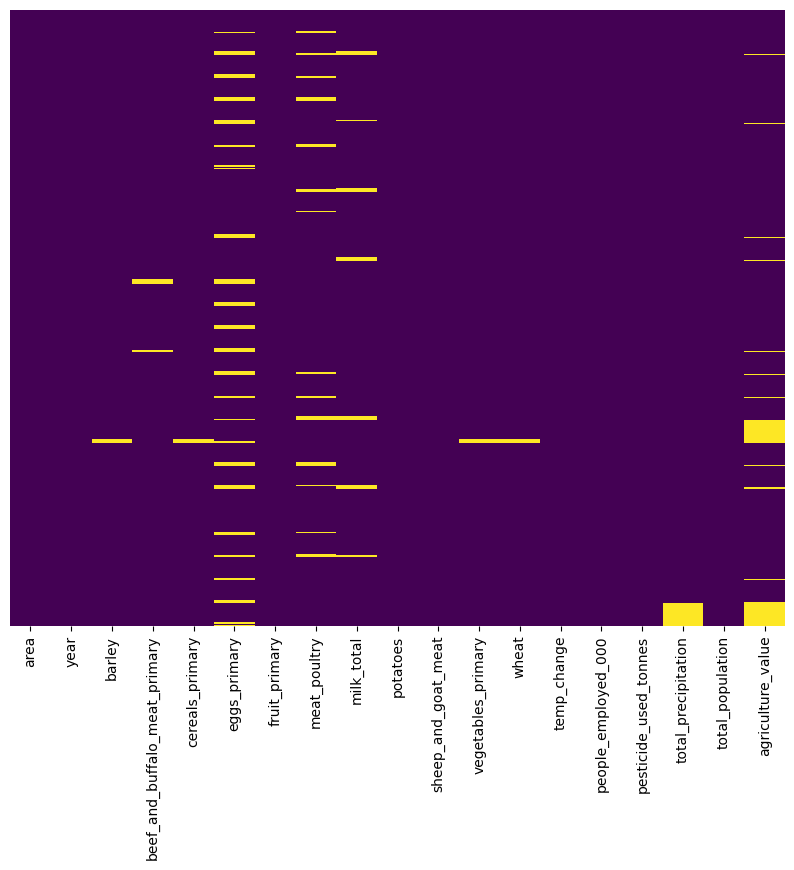

In [108]:
# Displaying missing values in the dataset
plt.figure(figsize=(10,8))
sns.heatmap(df.isna(),yticklabels=False,cbar = False,cmap="viridis")

In [109]:
missing_columns = df.columns[df.isna().any()].tolist()
missing_columns = pd.DataFrame(missing_columns)


Displaying the distribution of the missign values to get a sense of the 

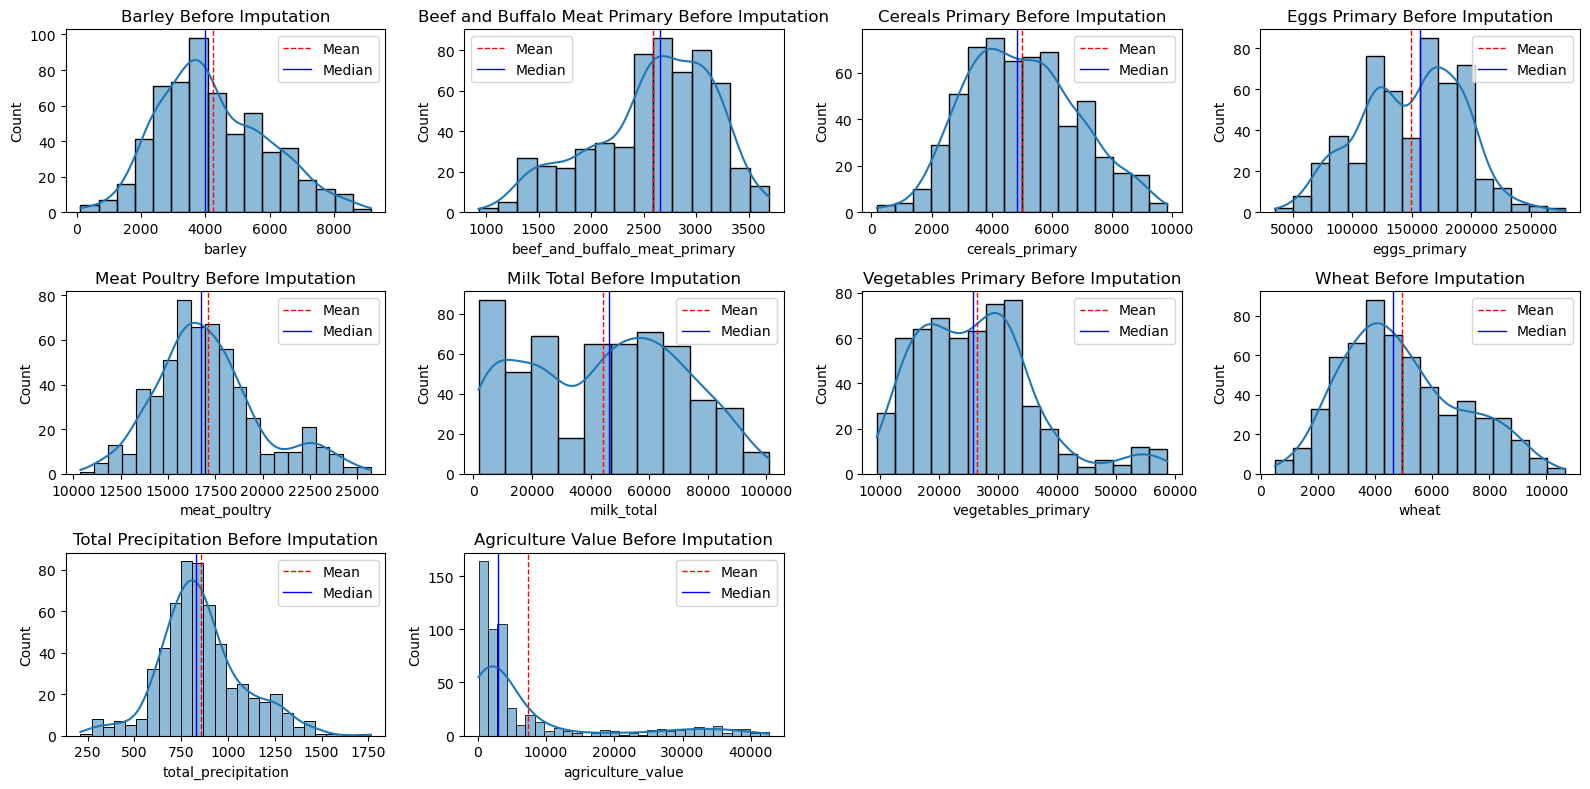

In [110]:
# Create a figure and axes with three rows and four columns
fig, axes = plt.subplots(3, 4, figsize=(16, 8))

# Function to plot a histogram with mean, median, and a legend
def plot_hist_with_legend(ax, data, title):
    sns.histplot(data, kde=True, ax=ax)
    ax.set_title(title)
    mean_line = ax.axvline(data.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    median_line = ax.axvline(data.median(), color='blue', linestyle='-', linewidth=1, label='Median')
    ax.legend(loc='best')  # Add legend to the plot

# Plot histograms for the first row
plot_hist_with_legend(axes[0, 0], df['barley'], 'Barley Before Imputation')
plot_hist_with_legend(axes[0, 1], df['beef_and_buffalo_meat_primary'], 'Beef and Buffalo Meat Primary Before Imputation')
plot_hist_with_legend(axes[0, 2], df['cereals_primary'], 'Cereals Primary Before Imputation')
plot_hist_with_legend(axes[0, 3], df['eggs_primary'], 'Eggs Primary Before Imputation')

# Plot histograms for the second row
plot_hist_with_legend(axes[1, 0], df['meat_poultry'], 'Meat Poultry Before Imputation')
plot_hist_with_legend(axes[1, 1], df['milk_total'], 'Milk Total Before Imputation')
plot_hist_with_legend(axes[1, 2], df['vegetables_primary'], 'Vegetables Primary Before Imputation')
plot_hist_with_legend(axes[1, 3], df['wheat'], 'Wheat Before Imputation')

# Plot histograms for the third row
plot_hist_with_legend(axes[2, 0], df['total_precipitation'], 'Total Precipitation Before Imputation')
plot_hist_with_legend(axes[2, 1], df['agriculture_value'], 'Agriculture Value Before Imputation')

# Hide the empty subplots in the third row (bottom-right corner)
axes[2, 2].axis('off')
axes[2, 3].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [111]:
# Further investigating the normal distribution of the missing data columns for mean and median similarity 
df.describe()

,year,barley,beef_and_buffalo_meat_primary,cereals_primary,eggs_primary,fruit_primary,meat_poultry,milk_total,potatoes,sheep_and_goat_meat,vegetables_primary,wheat,temp_change,people_employed_000,pesticide_used_tonnes,total_precipitation,total_population,agriculture_value
count,594.000000,590.000000,588.000000,590.000000,523.000000,594.000000,560.000000,571.000000,594.000000,594.000000,590.000000,590.000000,594.000000,594.000000,594.000000,572.000000,594.000000,538.000000
mean,2010.500000,4229.087627,2587.000000,5005.842712,149387.047801,10984.303872,17119.764286,44243.098074,26430.732997,166.090909,26308.864576,4939.588983,1.426678,1157.720471,12919.918603,857.475573,16225.197855,7305.445703
std,6.349636,1669.996814,575.465139,1832.394403,42609.495037,7730.688824,2780.386241,26625.890268,10053.130596,45.784028,10183.088220,2070.897249,0.611957,1365.456347,21269.146643,224.033535,21203.054499,10790.917633
min,2000.000000,114.000000,929.000000,176.300000,35189.000000,520.300000,10385.000000,1772.000000,5944.000000,78.000000,9398.100000,495.400000,-0.279000,10.240000,75.600000,211.824970,399.212000,114.196741
25%,2005.000000,3034.025000,2248.750000,3603.800000,118477.000000,6414.675000,15401.750000,21014.500000,18170.400000,120.250000,18548.175000,3449.075000,1.021500,276.460000,1563.787500,715.555385,3385.797500,1169.560974
50%,2010.500000,3979.150000,2658.500000,4835.900000,156600.000000,9529.700000,16746.000000,46393.000000,25022.050000,175.500000,25765.000000,4615.000000,1.393500,513.640000,3806.585000,829.285020,8377.014500,2930.915109
75%,2016.000000,5402.825000,3031.000000,6201.100000,181829.500000,13671.625000,18418.750000,65417.000000,33271.600000,203.000000,31827.300000,6254.000000,1.851750,1271.455000,10255.255000,970.529225,16245.382000,6926.645941
max,2021.000000,9145.700000,3695.000000,9842.200000,279087.000000,44196.200000,25718.000000,100966.000000,54000.300000,300.000000,58662.800000,10667.700000,3.598000,6246.270000,99694.000000,1763.293000,83408.554000,42678.495564


In [112]:
def impute_missing_with_interpolation(df):
    """
    Imputes missing values in numeric columns of the DataFrame using linear interpolation.

    Parameters:
        df (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The DataFrame with missing values imputed using interpolation.
    """
    for column in df.columns:
        try:
            # Check if the column has missing values
            if df[column].isnull().sum() > 0:
                # Check if the column is numeric
                if pd.api.types.is_numeric_dtype(df[column]):
                    df[column].interpolate(method='linear', inplace=True)  # Perform linear interpolation
                else:
                    print(f"Skipping non-numeric column: {column}")
        except Exception as e:
            print(f"An error occurred while processing column '{column}': {e}")
    
    return df

# Example usage
# df = pd.read_csv('your_data.csv')
df = impute_missing_with_interpolation(df)

<Axes: >

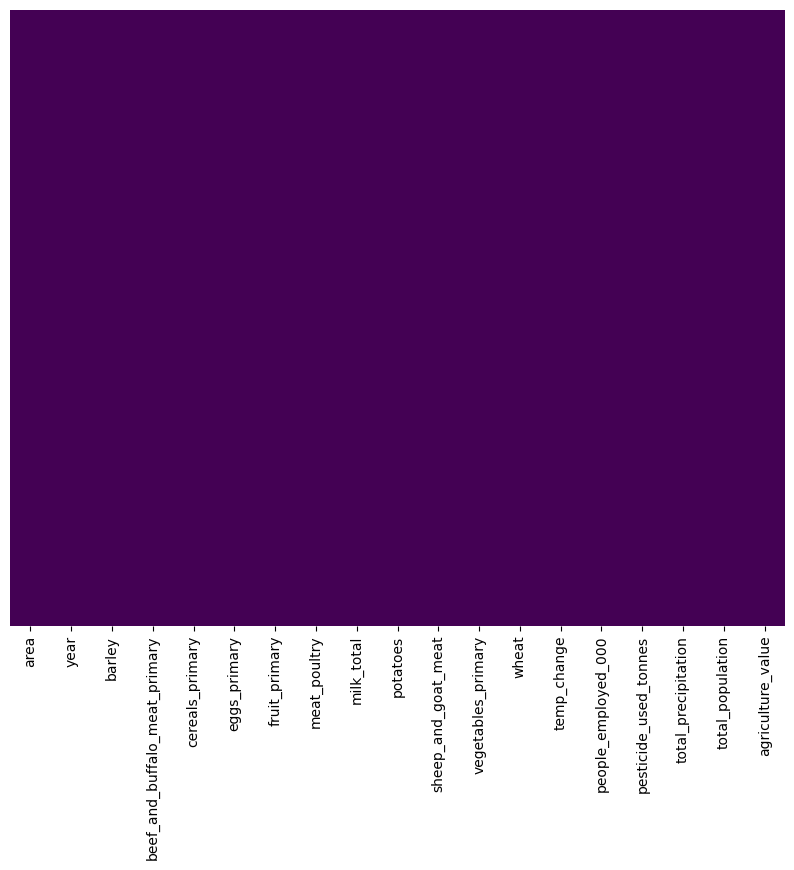

In [113]:
# Displaying missing values in the dataset
plt.figure(figsize=(10,8))
sns.heatmap(df.isna(),yticklabels=False,cbar = False,cmap="viridis")

In [114]:
df.isna().sum()

area                             0
year                             0
barley                           0
beef_and_buffalo_meat_primary    0
cereals_primary                  0
eggs_primary                     0
fruit_primary                    0
meat_poultry                     0
milk_total                       0
potatoes                         0
sheep_and_goat_meat              0
vegetables_primary               0
wheat                            0
temp_change                      0
people_employed_000              0
pesticide_used_tonnes            0
total_precipitation              0
total_population                 0
agriculture_value                0
dtype: int64

## Displaying the distributions again to ensure their distributions have not changed significantly 

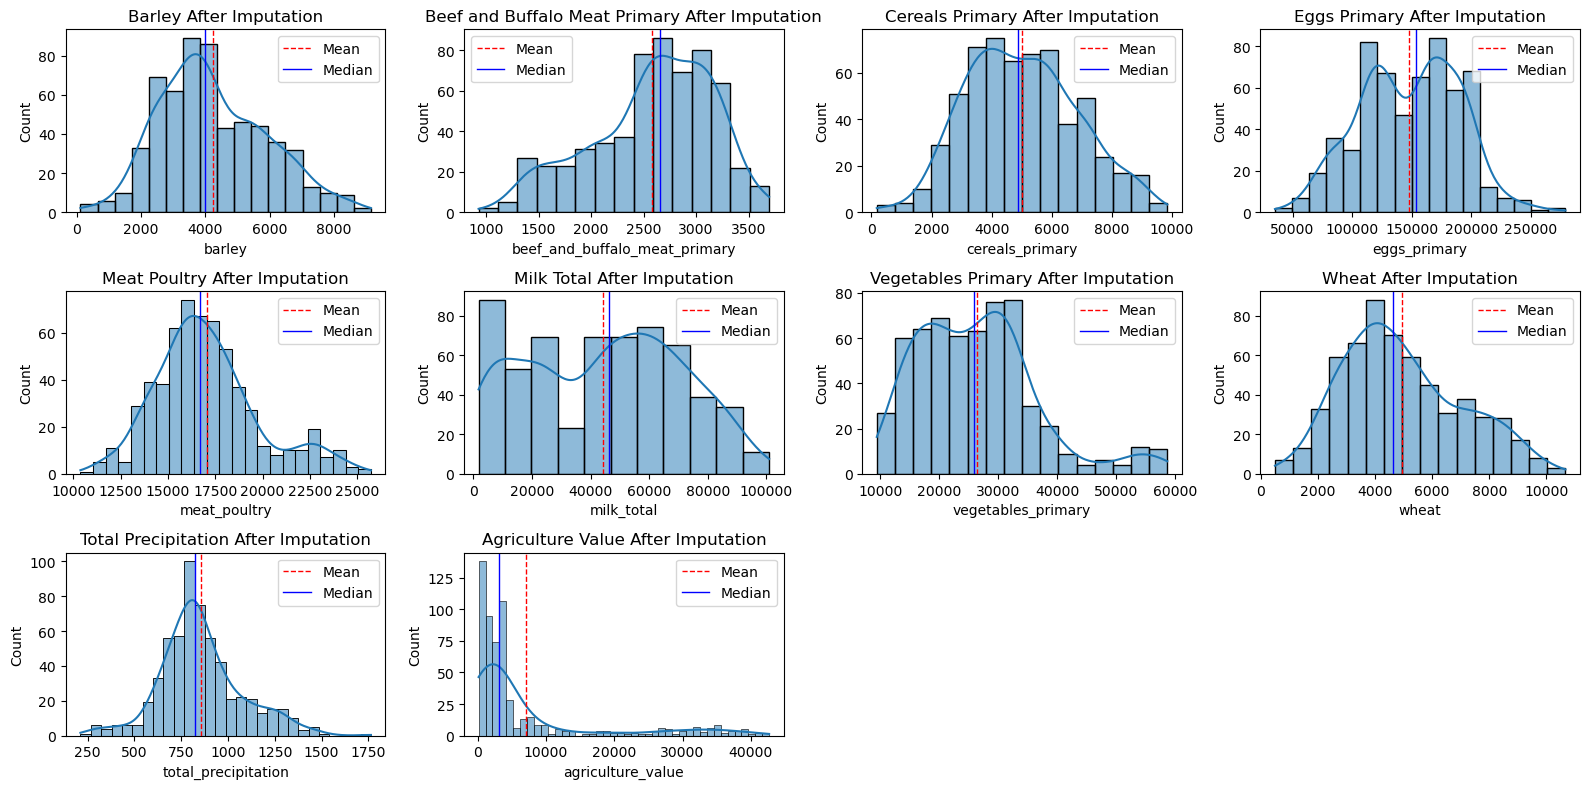

In [115]:
# Create a figure and axes with three rows and four columns
fig, axes = plt.subplots(3, 4, figsize=(16, 8))

# Plot histograms for the first row
plot_hist_with_legend(axes[0, 0], df['barley'], 'Barley After Imputation')
plot_hist_with_legend(axes[0, 1], df['beef_and_buffalo_meat_primary'], 'Beef and Buffalo Meat Primary After Imputation')
plot_hist_with_legend(axes[0, 2], df['cereals_primary'], 'Cereals Primary After Imputation')
plot_hist_with_legend(axes[0, 3], df['eggs_primary'], 'Eggs Primary After Imputation')

# Plot histograms for the second row
plot_hist_with_legend(axes[1, 0], df['meat_poultry'], 'Meat Poultry After Imputation')
plot_hist_with_legend(axes[1, 1], df['milk_total'], 'Milk Total After Imputation')
plot_hist_with_legend(axes[1, 2], df['vegetables_primary'], 'Vegetables Primary After Imputation')
plot_hist_with_legend(axes[1, 3], df['wheat'], 'Wheat After Imputation')

# Plot histograms for the third row
plot_hist_with_legend(axes[2, 0], df['total_precipitation'], 'Total Precipitation After Imputation')
plot_hist_with_legend(axes[2, 1], df['agriculture_value'], 'Agriculture Value After Imputation')

# Hide the empty subplots in the third row (bottom-right corner)
axes[2, 2].axis('off')
axes[2, 3].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [116]:
df.head()

,area,year,barley,beef_and_buffalo_meat_primary,cereals_primary,eggs_primary,fruit_primary,meat_poultry,milk_total,potatoes,sheep_and_goat_meat,vegetables_primary,wheat,temp_change,people_employed_000,pesticide_used_tonnes,total_precipitation,total_population,agriculture_value
0,Austria,2000,3819.5,3031.0,5403.9,165011.0,16294.6,17063.0,47916.0,29262.7,204.0,38431.1,4468.8,1.774,766.87,3563.2,1271.30250,8010.428,2443.834497
1,Austria,2001,4655.3,2993.0,5856.2,164992.0,15484.6,17531.0,49589.0,30039.4,212.0,40500.1,5241.2,1.508,718.74,3132.2,1231.89840,8039.626,2527.762615
2,Austria,2002,4286.6,2995.0,5831.0,164986.0,16201.2,17664.0,50362.0,30383.2,213.0,41954.2,4966.7,1.542,703.31,3079.2,1339.83100,8078.992,2489.281305
3,Austria,2003,4155.9,3033.0,5255.4,165013.0,16950.5,17718.0,51759.0,26528.7,211.0,37718.6,4380.1,1.474,734.47,3384.9,964.65704,8120.104,2926.230271
4,Austria,2004,5261.7,3058.0,6495.5,165005.0,17905.3,18297.0,54121.0,31611.7,208.0,40853.2,5923.4,0.840,716.11,3301.7,1228.85990,8171.217,3375.140464


In [117]:
# Adding country codes obtained from https://www.revenue.ie/en/vat/documents/eu-states-codes.pdf 
country_codes = {
    'Austria': 'AUT',
    'Belgium': 'BEL',
    'Bulgaria': 'BGR',
    'Croatia': 'HRV',
    'Cyprus': 'CYP',
    'Czechia': 'CZE',
    'Denmark': 'DNK',
    'Estonia': 'EST',
    'Finland': 'FIN',
    'France': 'FRA',
    'Germany': 'DEU',
    'Greece': 'GRC',
    'Hungary': 'HUN',
    'Ireland': 'IRL',
    'Italy': 'ITA',
    'Latvia': 'LVA',
    'Lithuania': 'LTU',
    'Luxembourg': 'LUX',
    'Malta': 'MLT',
    'Netherlands (Kingdom of the)': 'NLD',
    'Poland': 'POL',
    'Portugal': 'PRT',
    'Romania': 'ROU',
    'Slovakia': 'SVK',
    'Slovenia': 'SVN',
    'Spain': 'ESP',
    'Sweden': 'SWE'
}
df['country_code'] = df['area'].map(country_codes)

In [118]:
#For visuals its easier to have a Datetime column to reference for time 

df['year'] = pd.to_datetime(df['year'], format='%Y', errors='coerce')
#df['year'] = df['year'].dt.year

df.to_csv('df.csv', index=False)

In [119]:
df.head()

,area,year,barley,beef_and_buffalo_meat_primary,cereals_primary,eggs_primary,fruit_primary,meat_poultry,milk_total,potatoes,sheep_and_goat_meat,vegetables_primary,wheat,temp_change,people_employed_000,pesticide_used_tonnes,total_precipitation,total_population,agriculture_value,country_code
0,Austria,2000-01-01,3819.5,3031.0,5403.9,165011.0,16294.6,17063.0,47916.0,29262.7,204.0,38431.1,4468.8,1.774,766.87,3563.2,1271.30250,8010.428,2443.834497,AUT
1,Austria,2001-01-01,4655.3,2993.0,5856.2,164992.0,15484.6,17531.0,49589.0,30039.4,212.0,40500.1,5241.2,1.508,718.74,3132.2,1231.89840,8039.626,2527.762615,AUT
2,Austria,2002-01-01,4286.6,2995.0,5831.0,164986.0,16201.2,17664.0,50362.0,30383.2,213.0,41954.2,4966.7,1.542,703.31,3079.2,1339.83100,8078.992,2489.281305,AUT
3,Austria,2003-01-01,4155.9,3033.0,5255.4,165013.0,16950.5,17718.0,51759.0,26528.7,211.0,37718.6,4380.1,1.474,734.47,3384.9,964.65704,8120.104,2926.230271,AUT
4,Austria,2004-01-01,5261.7,3058.0,6495.5,165005.0,17905.3,18297.0,54121.0,31611.7,208.0,40853.2,5923.4,0.840,716.11,3301.7,1228.85990,8171.217,3375.140464,AUT


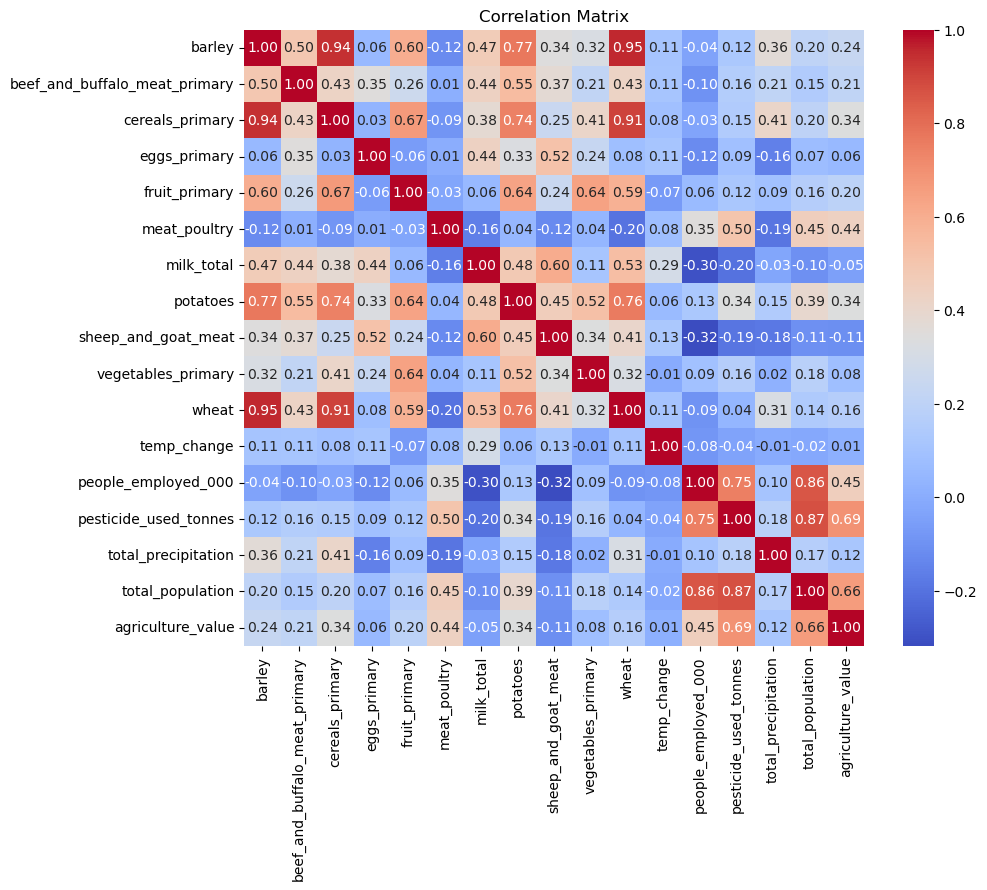

In [120]:
# Compute the correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])  # Include only numeric columns
correlation_matrix = numeric_df.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [121]:
correlation_matrix


,barley,beef_and_buffalo_meat_primary,cereals_primary,eggs_primary,fruit_primary,meat_poultry,milk_total,potatoes,sheep_and_goat_meat,vegetables_primary,wheat,temp_change,people_employed_000,pesticide_used_tonnes,total_precipitation,total_population,agriculture_value
barley,1.000000,0.495352,0.940701,0.056006,0.599828,-0.121053,0.467906,0.771293,0.342641,0.315415,0.953906,0.108406,-0.038084,0.124832,0.363951,0.204049,0.236812
beef_and_buffalo_meat_primary,0.495352,1.000000,0.427921,0.350085,0.263628,0.007251,0.435293,0.546913,0.373776,0.214423,0.426292,0.113657,-0.100995,0.157310,0.207991,0.148843,0.212174
cereals_primary,0.940701,0.427921,1.000000,0.030630,0.668353,-0.086666,0.377109,0.743601,0.246080,0.409974,0.906275,0.084892,-0.032190,0.149864,0.412388,0.199973,0.336543
eggs_primary,0.056006,0.350085,0.030630,1.000000,-0.064231,0.005808,0.437078,0.326088,0.515768,0.235552,0.082077,0.111462,-0.118939,0.086209,-0.155640,0.068761,0.057629
fruit_primary,0.599828,0.263628,0.668353,-0.064231,1.000000,-0.027229,0.057214,0.638770,0.243919,0.644054,0.586656,-0.066667,0.061659,0.122212,0.092420,0.164723,0.196707
meat_poultry,-0.121053,0.007251,-0.086666,0.005808,-0.027229,1.000000,-0.161810,0.044585,-0.123997,0.041155,-0.195090,0.076218,0.346517,0.504517,-0.193675,0.452703,0.437733
milk_total,0.467906,0.435293,0.377109,0.437078,0.057214,-0.161810,1.000000,0.481042,0.604334,0.112794,0.534760,0.292611,-0.299932,-0.200007,-0.026208,-0.102628,-0.046118
potatoes,0.771293,0.546913,0.743601,0.326088,0.638770,0.044585,0.481042,1.000000,0.454643,0.523270,0.761172,0.061046,0.128280,0.337376,0.148457,0.394554,0.338059
sheep_and_goat_meat,0.342641,0.373776,0.246080,0.515768,0.243919,-0.123997,0.604334,0.454643,1.000000,0.336421,0.406780,0.128228,-0.317932,-0.192404,-0.181049,-0.106346,-0.106997
vegetables_primary,0.315415,0.214423,0.409974,0.235552,0.644054,0.041155,0.112794,0.523270,0.336421,1.000000,0.320438,-0.007066,0.090285,0.164843,0.019338,0.176468,0.078904


## EDA on cleaned dataset

In [122]:
df.describe()

,year,barley,beef_and_buffalo_meat_primary,cereals_primary,eggs_primary,fruit_primary,meat_poultry,milk_total,potatoes,sheep_and_goat_meat,vegetables_primary,wheat,temp_change,people_employed_000,pesticide_used_tonnes,total_precipitation,total_population,agriculture_value
count,594,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,2010-07-02 12:00:00,4235.207239,2582.988215,5015.181818,148127.942761,10984.303872,17045.094276,44339.332492,26430.732997,166.090909,26361.606902,4951.410943,1.426678,1157.720471,12919.918603,855.719822,16225.197855,7012.684884
min,2000-01-01 00:00:00,114.000000,929.000000,176.300000,35189.000000,520.300000,10385.000000,1772.000000,5944.000000,78.000000,9398.100000,495.400000,-0.279000,10.240000,75.600000,211.824970,399.212000,114.196741
25%,2005-01-01 00:00:00,3043.850000,2250.250000,3607.450000,117285.500000,6414.675000,15367.750000,21655.000000,18170.400000,120.250000,18555.650000,3453.925000,1.021500,276.460000,1563.787500,723.089275,3385.797500,1243.858492
50%,2010-07-02 12:00:00,3992.800000,2654.500000,4858.350000,153589.500000,9529.700000,16707.500000,46374.500000,25022.050000,175.500000,25894.550000,4639.700000,1.393500,513.640000,3806.585000,823.040300,8377.014500,3036.971108
75%,2016-01-01 00:00:00,5402.825000,3029.000000,6212.525000,180616.750000,13671.625000,18295.250000,65252.250000,33271.600000,203.000000,31872.925000,6276.150000,1.851750,1271.455000,10255.255000,962.498525,16245.382000,5510.611138
max,2021-01-01 00:00:00,9145.700000,3695.000000,9842.200000,279087.000000,44196.200000,25718.000000,100966.000000,54000.300000,300.000000,58662.800000,10667.700000,3.598000,6246.270000,99694.000000,1763.293000,83408.554000,42678.495564
std,NaN,1666.399247,574.249195,1830.572171,41644.712880,7730.688824,2740.290419,26402.508119,10053.130596,45.784028,10195.856048,2069.799988,0.611957,1365.456347,21269.146643,220.021016,21203.054499,10409.748701


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   area                           594 non-null    object        
 1   year                           594 non-null    datetime64[ns]
 2   barley                         594 non-null    float64       
 3   beef_and_buffalo_meat_primary  594 non-null    float64       
 4   cereals_primary                594 non-null    float64       
 5   eggs_primary                   594 non-null    float64       
 6   fruit_primary                  594 non-null    float64       
 7   meat_poultry                   594 non-null    float64       
 8   milk_total                     594 non-null    float64       
 9   potatoes                       594 non-null    float64       
 10  sheep_and_goat_meat            594 non-null    float64       
 11  vegetables_primary 

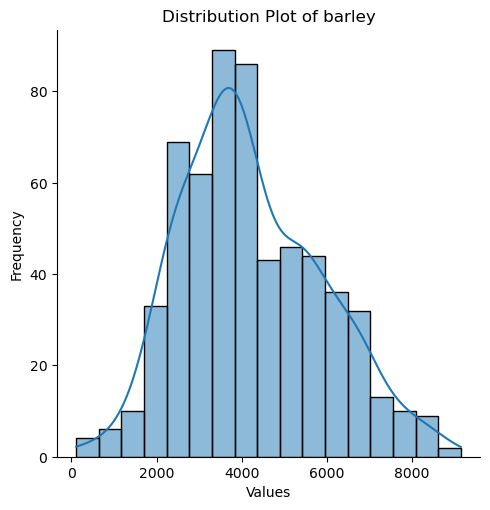

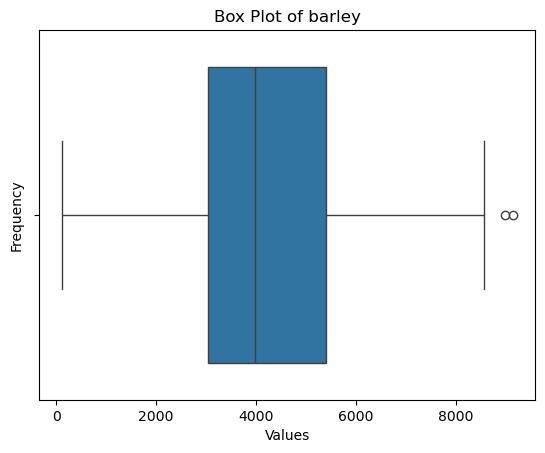

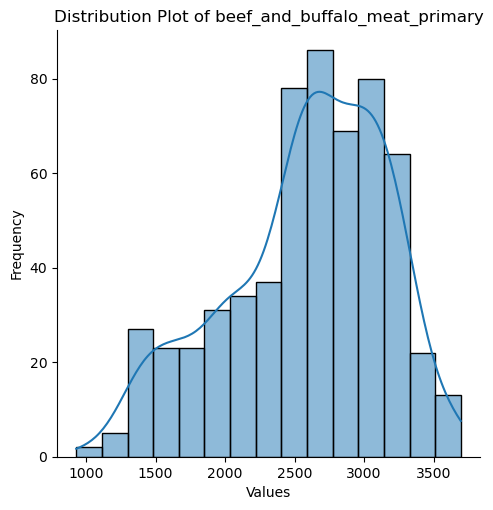

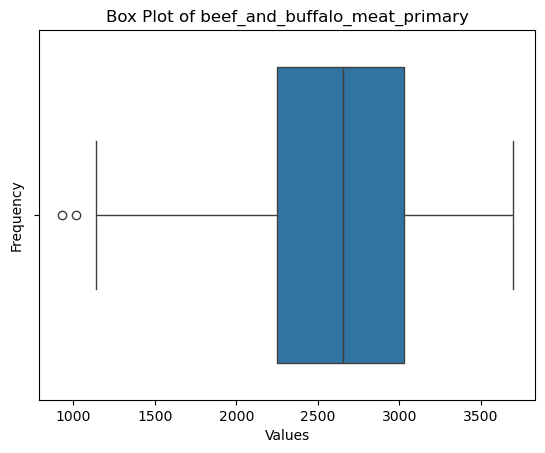

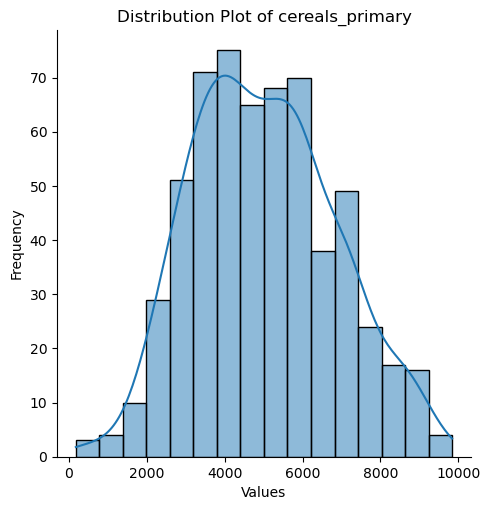

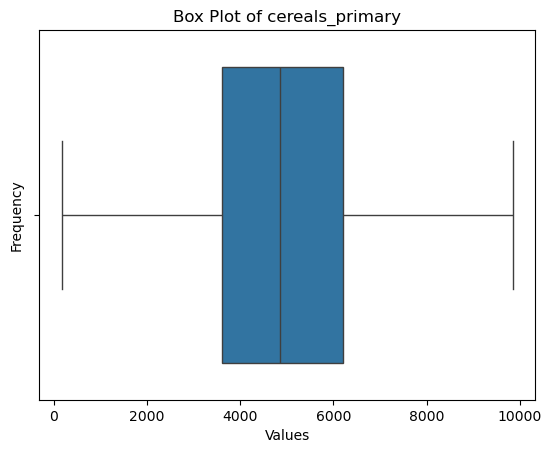

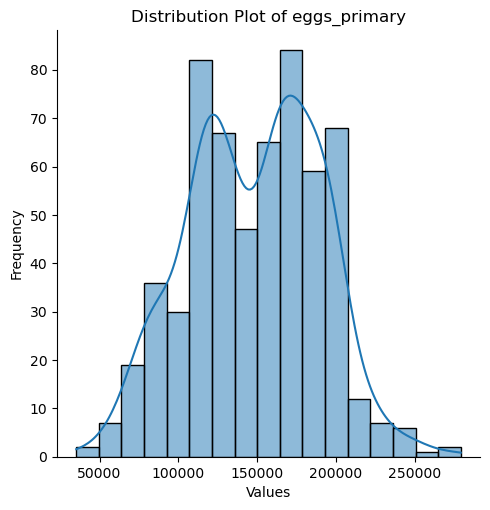

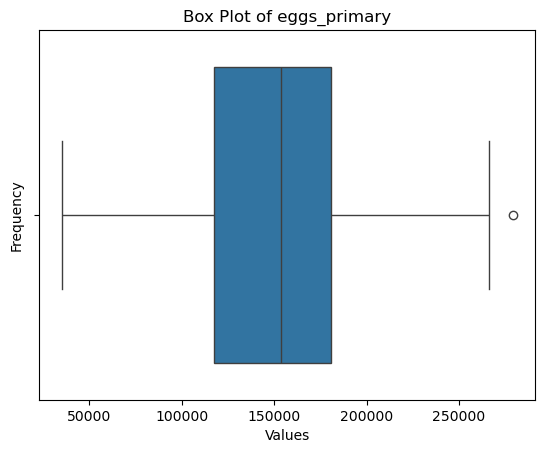

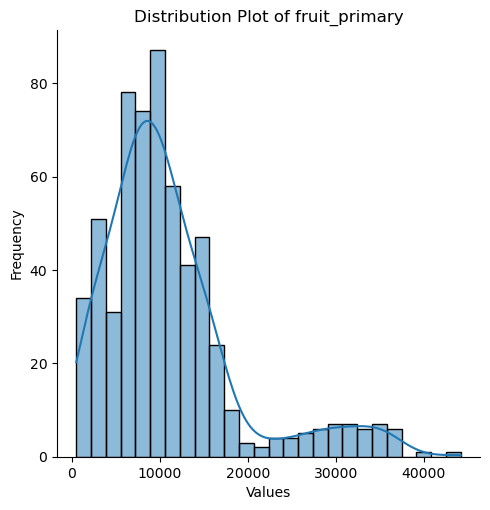

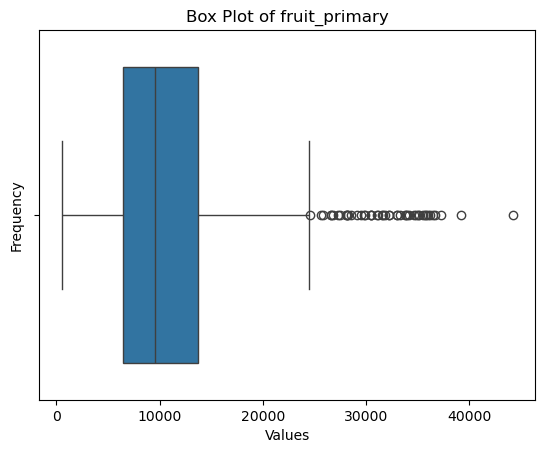

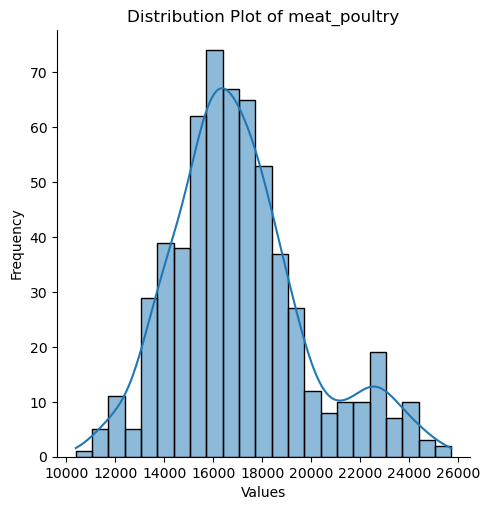

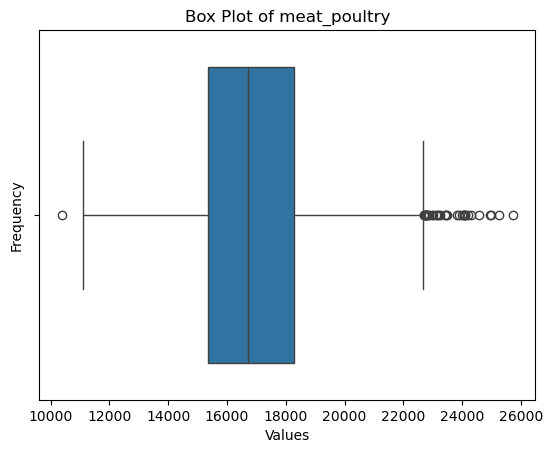

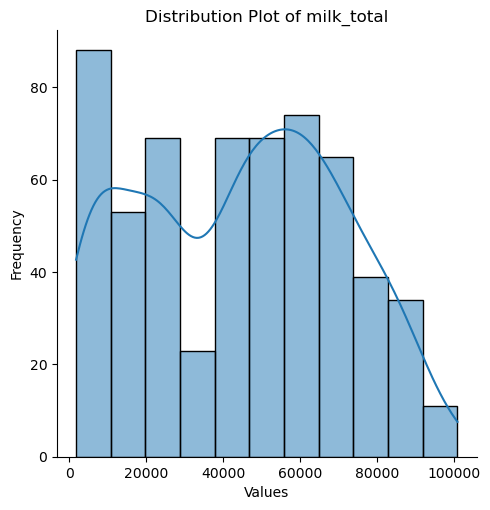

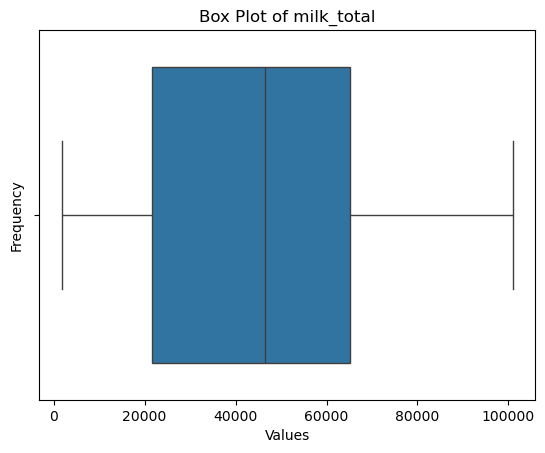

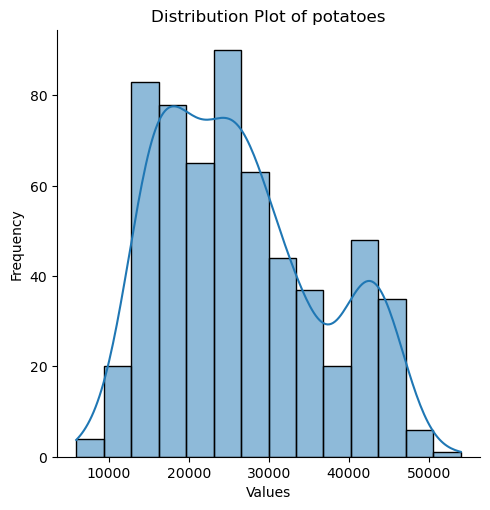

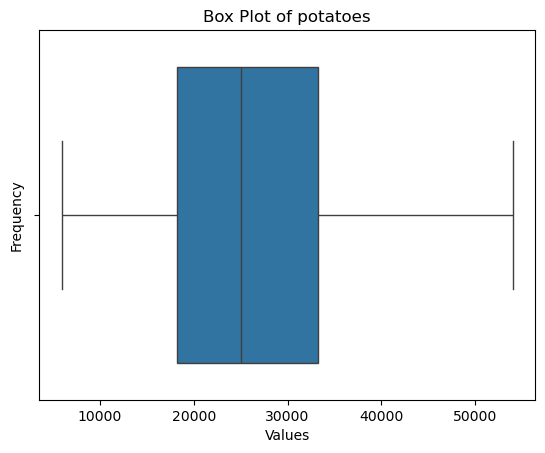

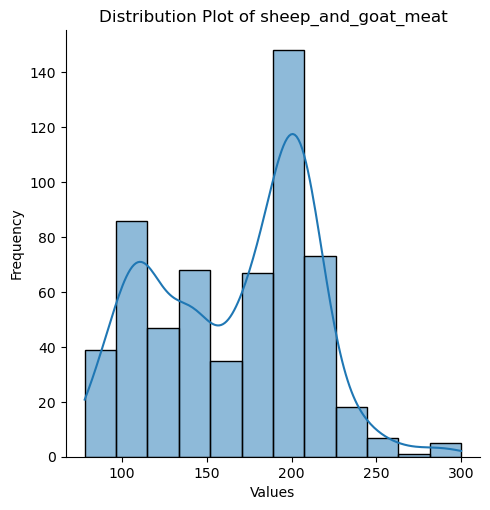

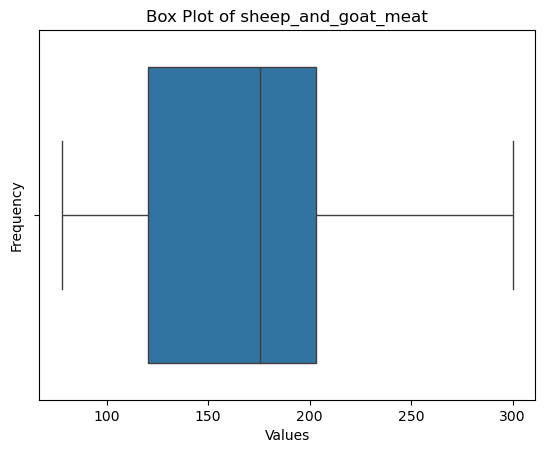

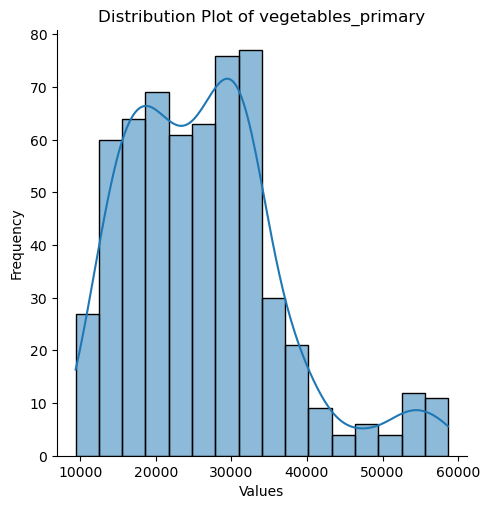

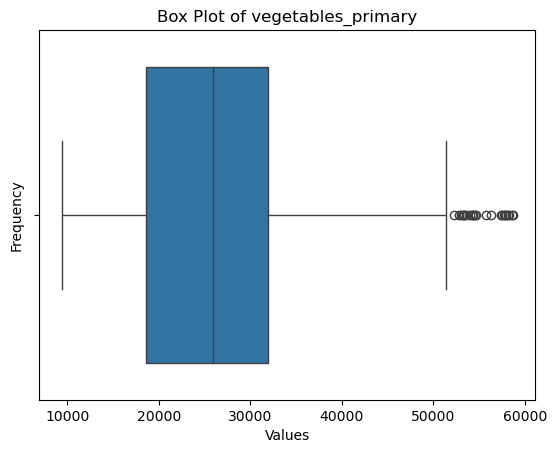

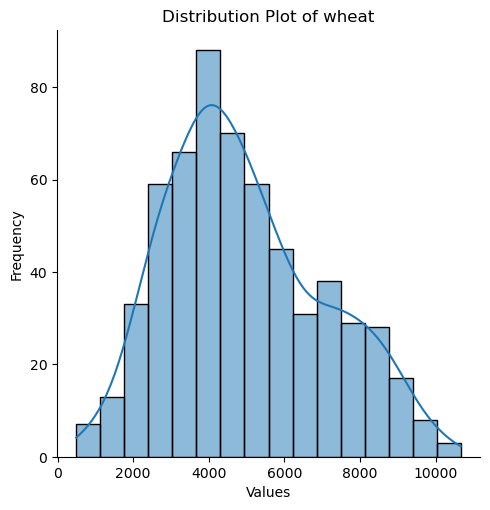

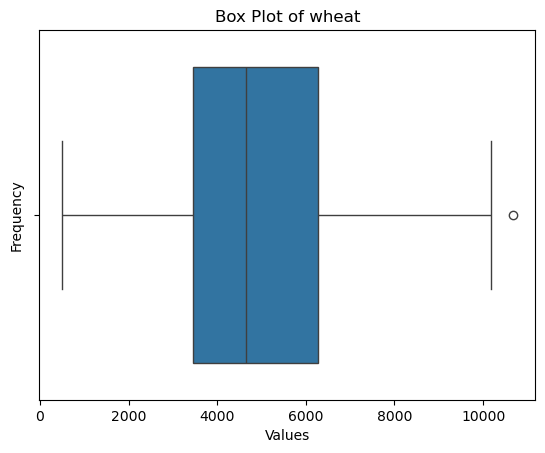

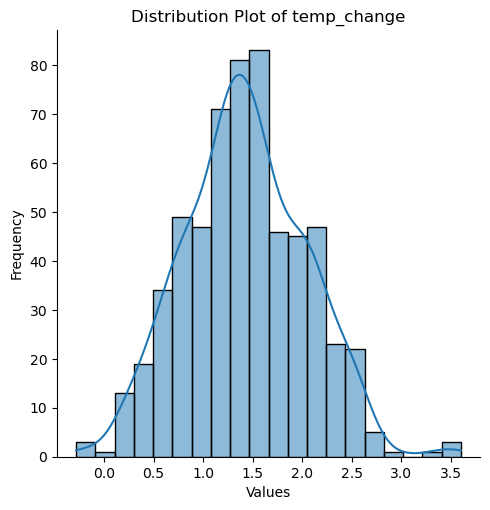

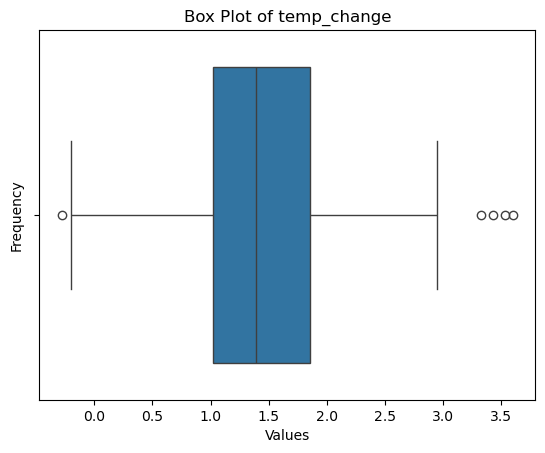

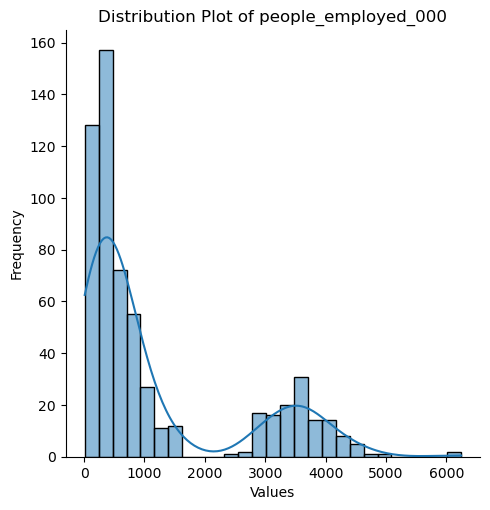

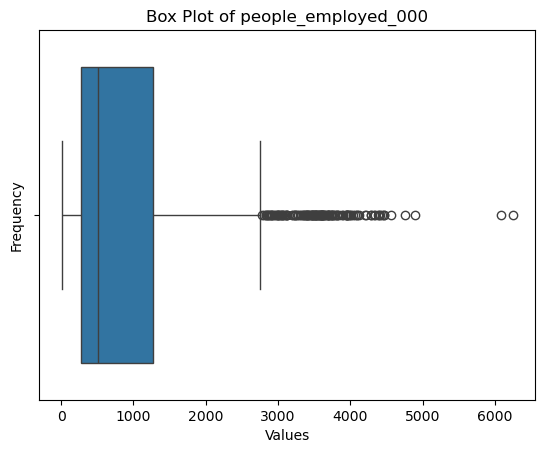

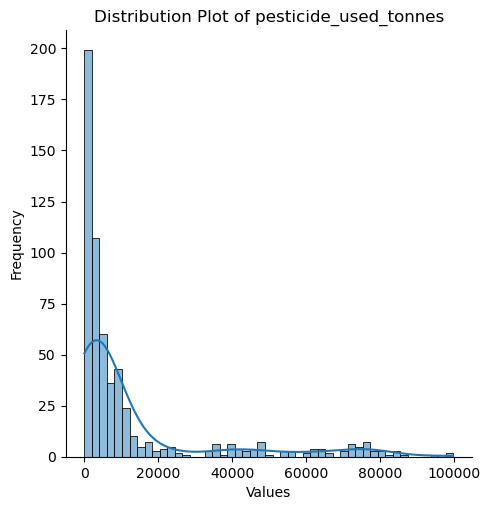

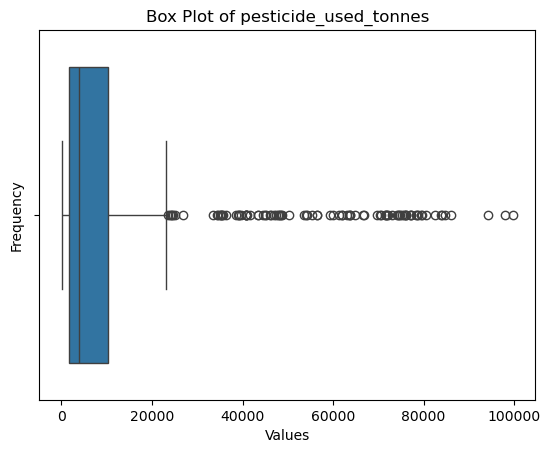

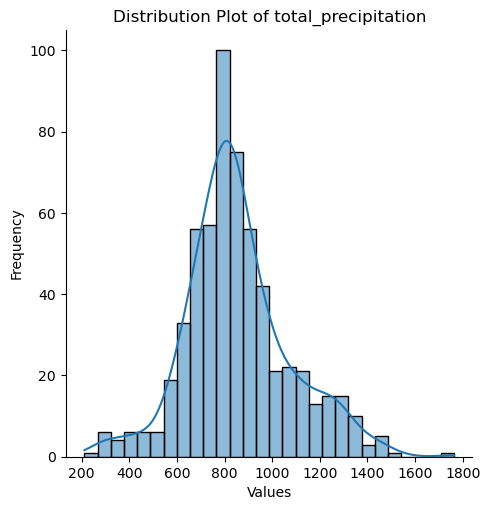

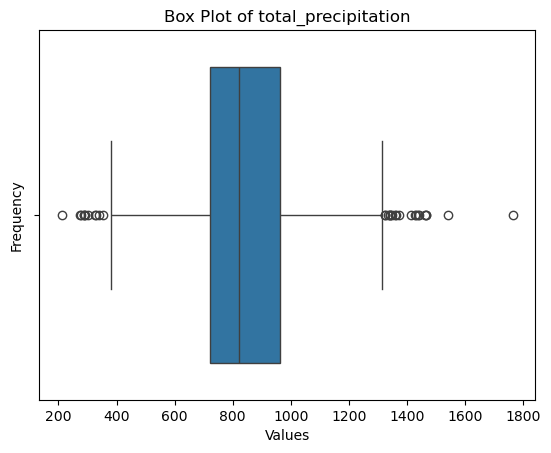

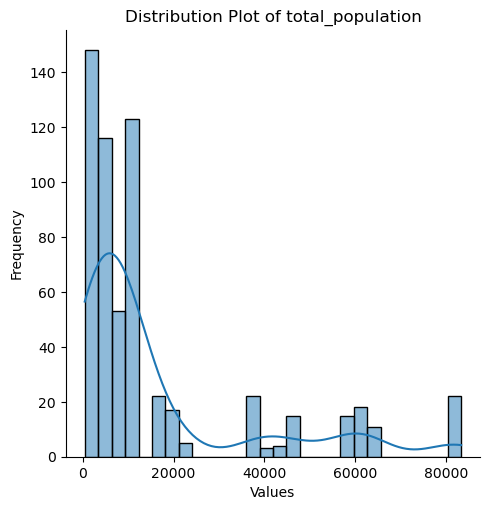

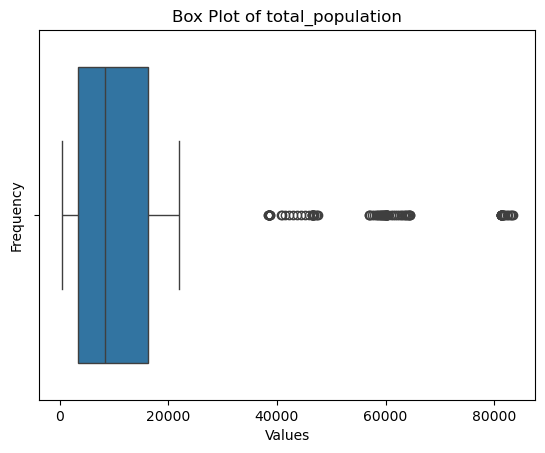

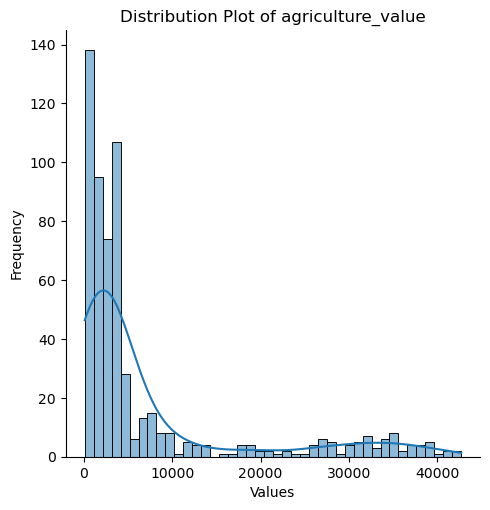

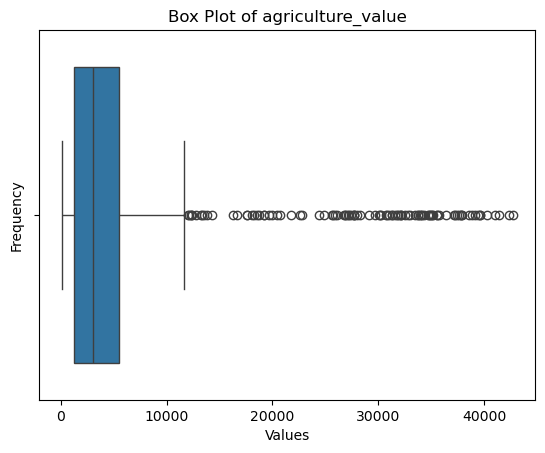

In [124]:
# Check if the the data is normally distributed
# Loop through each column in the DataFrame
for column in df.columns:
    # Create a distribution plot for numeric columns
    if pd.api.types.is_numeric_dtype(df[column]):
        sns.displot(data=df, x=column, kde=True)
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.title(f'Distribution Plot of {column}')
        plt.show();
        
        sns.boxplot(data=df, x=column)
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.title(f'Box Plot of {column}')
        plt.show();

## Creating a single figure of boxplots and histograms 

In [125]:
df.columns

Index(['area', 'year', 'barley', 'beef_and_buffalo_meat_primary',
       'cereals_primary', 'eggs_primary', 'fruit_primary', 'meat_poultry',
       'milk_total', 'potatoes', 'sheep_and_goat_meat', 'vegetables_primary',
       'wheat', 'temp_change', 'people_employed_000', 'pesticide_used_tonnes',
       'total_precipitation', 'total_population', 'agriculture_value',
       'country_code'],
      dtype='object')

In [126]:
# Function to plot a histogram with mean, median, and a legend
def plot_hist_without_legend(ax, data, title):
    sns.histplot(data, kde=True, ax=ax)
    ax.set_title(title)
    mean_line = ax.axvline(data.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    median_line = ax.axvline(data.median(), color='blue', linestyle='-', linewidth=1, label='Median')
    #ax.legend(loc='best')  # Add legend to the plot

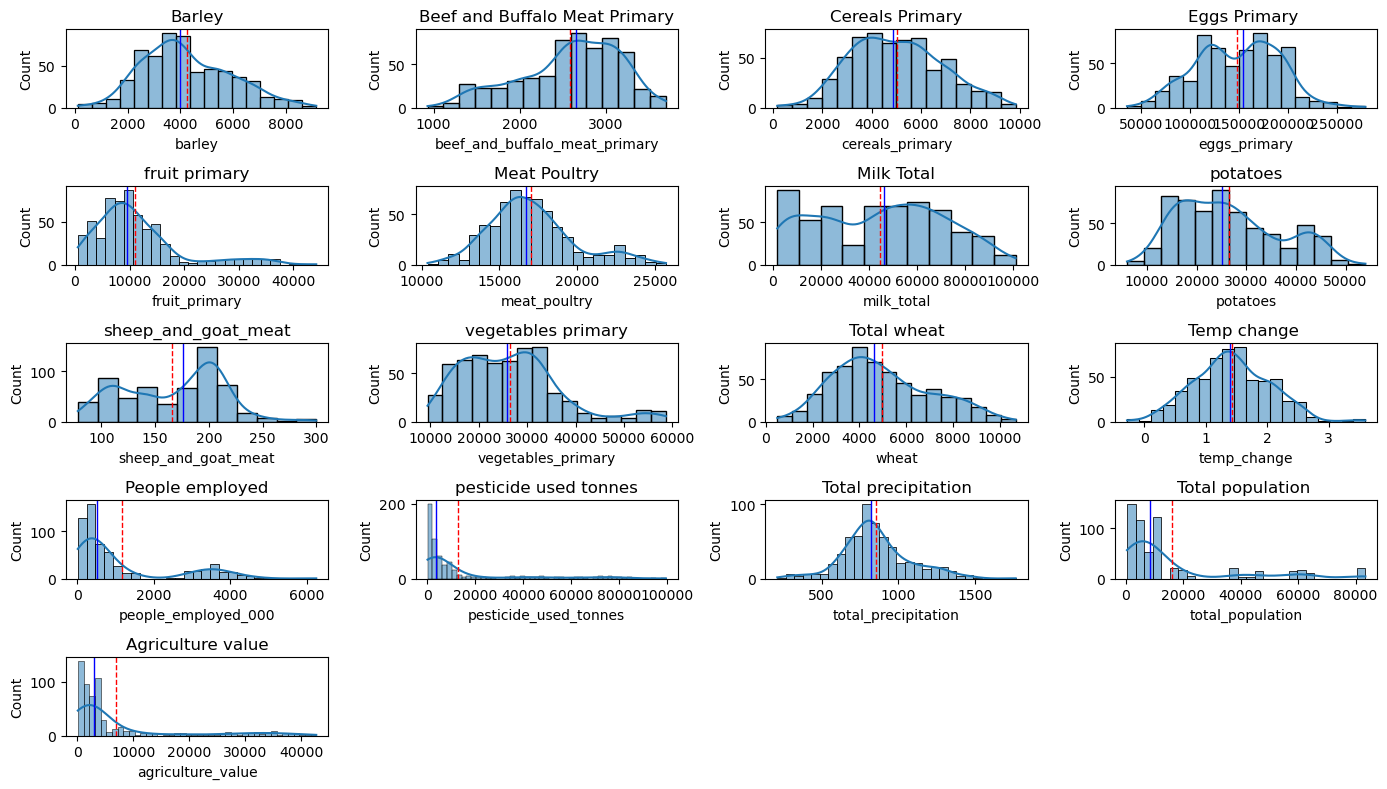

In [127]:
# Create a figure and axes with three rows and four columns
fig, axes = plt.subplots(5, 4, figsize=(14, 8))

# Plot histograms for the first row
plot_hist_without_legend(axes[0, 0], df['barley'], 'Barley')
plot_hist_without_legend(axes[0, 1], df['beef_and_buffalo_meat_primary'], 'Beef and Buffalo Meat Primary')
plot_hist_without_legend(axes[0, 2], df['cereals_primary'], 'Cereals Primary')
plot_hist_without_legend(axes[0, 3], df['eggs_primary'], 'Eggs Primary ')

# Plot histograms for the second row
plot_hist_without_legend(axes[1, 0], df['fruit_primary'], 'fruit primary')
plot_hist_without_legend(axes[1, 1], df['meat_poultry'], 'Meat Poultry')
plot_hist_without_legend(axes[1, 2], df['milk_total'], 'Milk Total')
plot_hist_without_legend(axes[1, 3], df['potatoes'], 'potatoes')


# Plot histograms for the third row
plot_hist_without_legend(axes[2, 0], df['sheep_and_goat_meat'], 'sheep_and_goat_meat')
plot_hist_without_legend(axes[2, 1], df['vegetables_primary'], 'vegetables primary')
plot_hist_without_legend(axes[2, 2], df['wheat'], 'Total wheat')
plot_hist_without_legend(axes[2, 3], df['temp_change'], 'Temp change ')


# Plot histograms for the third row
plot_hist_without_legend(axes[3, 0], df['people_employed_000'], 'People employed')
plot_hist_without_legend(axes[3, 1], df['pesticide_used_tonnes'], 'pesticide used tonnes')
plot_hist_without_legend(axes[3, 2], df['total_precipitation'], 'Total precipitation')
plot_hist_without_legend(axes[3, 3], df['total_population'], 'Total population ')


plot_hist_without_legend(axes[4, 0], df['agriculture_value'], 'Agriculture value')

# Hide the empty subplots in the third row (bottom-right corner)
axes[4, 1].axis('off')
axes[4, 2].axis('off')
axes[4, 3].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot a boxplot with mean, median, and a legend
def plot_boxplot(ax, data, title):
    """
    Plots a boxplot of the given data and adds vertical lines for the mean and median.

    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axis to plot on.
        data (pd.Series or list): Data to plot as a boxplot.
        title (str): Title of the plot.

    Returns:
        None
    """
    sns.boxplot(data, ax=ax)  # Plot the boxplot
    ax.set_title(title)       # Set the title
    
    # Add mean and median lines with labels for the legend
    #mean_line = ax.axvline(data.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    #median_line = ax.axvline(data.median(), color='blue', linestyle='-', linewidth=1, label='Median')
    
    # Add a legend to the plot
    #ax.legend(handles=[mean_line, median_line], loc='best')


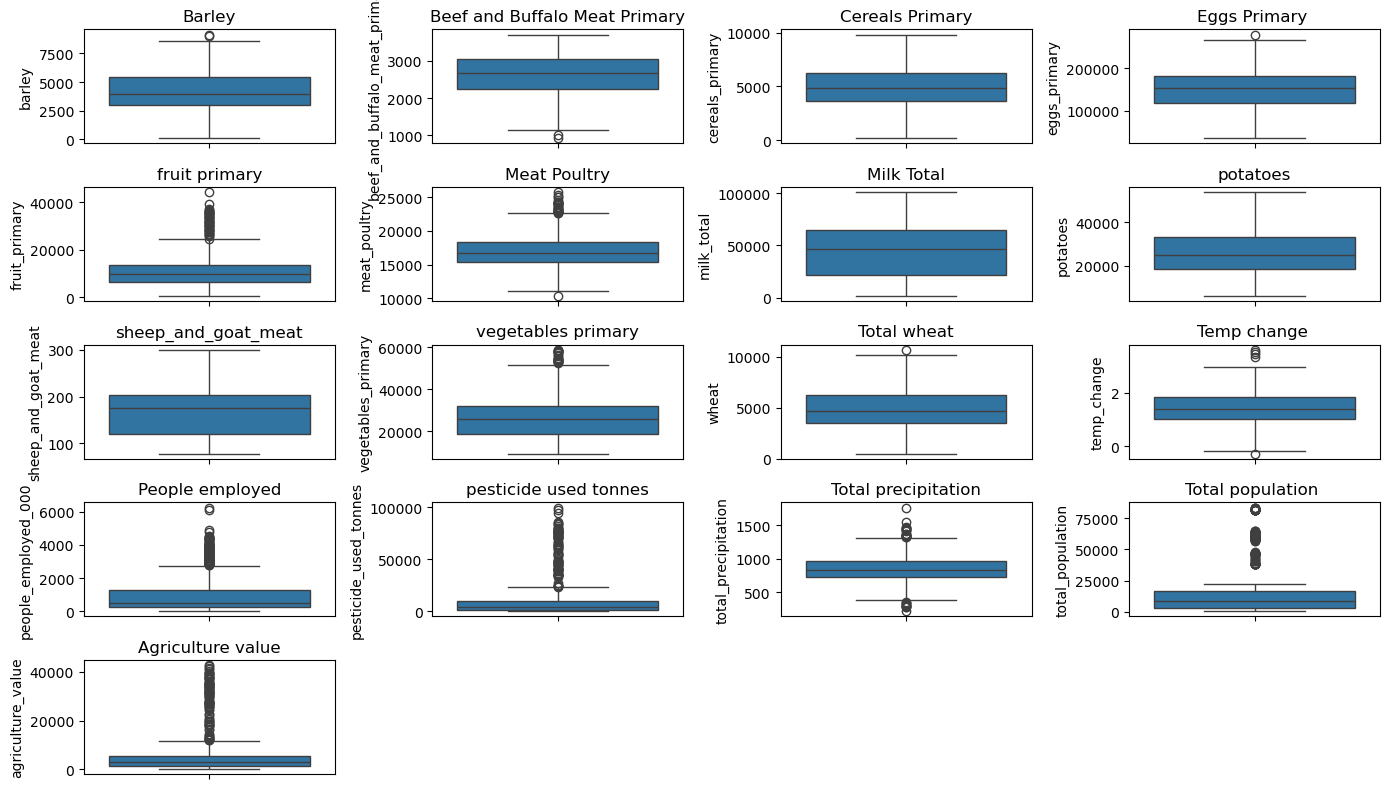

In [129]:
# Create a figure and axes with three rows and four columns
fig, axes = plt.subplots(5, 4, figsize=(14, 8))

# Plot histograms for the first row
plot_boxplot(axes[0, 0], df['barley'], 'Barley')
plot_boxplot(axes[0, 1], df['beef_and_buffalo_meat_primary'], 'Beef and Buffalo Meat Primary')
plot_boxplot(axes[0, 2], df['cereals_primary'], 'Cereals Primary')
plot_boxplot(axes[0, 3], df['eggs_primary'], 'Eggs Primary ')

# Plot histograms for the second row
plot_boxplot(axes[1, 0], df['fruit_primary'], 'fruit primary')
plot_boxplot(axes[1, 1], df['meat_poultry'], 'Meat Poultry')
plot_boxplot(axes[1, 2], df['milk_total'], 'Milk Total')
plot_boxplot(axes[1, 3], df['potatoes'], 'potatoes')


# Plot histograms for the third row
plot_boxplot(axes[2, 0], df['sheep_and_goat_meat'], 'sheep_and_goat_meat')
plot_boxplot(axes[2, 1], df['vegetables_primary'], 'vegetables primary')
plot_boxplot(axes[2, 2], df['wheat'], 'Total wheat')
plot_boxplot(axes[2, 3], df['temp_change'], 'Temp change ')


# Plot histograms for the third row
plot_boxplot(axes[3, 0], df['people_employed_000'], 'People employed')
plot_boxplot(axes[3, 1], df['pesticide_used_tonnes'], 'pesticide used tonnes')
plot_boxplot(axes[3, 2], df['total_precipitation'], 'Total precipitation')
plot_boxplot(axes[3, 3], df['total_population'], 'Total population ')


plot_boxplot(axes[4, 0], df['agriculture_value'], 'Agriculture value')

# Hide the empty subplots in the third row (bottom-right corner)
axes[4, 1].axis('off')
axes[4, 2].axis('off')
axes[4, 3].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [130]:
# Exclude non-numeric columns, like datetime
numeric_df = df.select_dtypes(include=['number'])

# Calculate kurtosis only for numeric columns
kurtosis_values = numeric_df.kurtosis()
print("Kurtosis Values ")
print(kurtosis_values)


Kurtosis Values 
barley                          -0.227505
beef_and_buffalo_meat_primary   -0.373033
cereals_primary                 -0.442151
eggs_primary                    -0.480408
fruit_primary                    2.787019
meat_poultry                     0.491993
milk_total                      -1.095561
potatoes                        -0.742383
sheep_and_goat_meat             -0.863706
vegetables_primary               0.971335
wheat                           -0.479095
temp_change                      0.069192
people_employed_000              0.340551
pesticide_used_tonnes            3.804568
total_precipitation              0.933756
total_population                 2.154319
agriculture_value                2.754241
dtype: float64


In [131]:
from scipy.stats import skew

# Exclude non-numeric columns, like datetime
numeric_df = df.select_dtypes(include=['number'])

# Calculate skew only for numeric columns
skew_values = numeric_df.skew()
print("Skew Values")
print(skew_values)

Skew Values
barley                           0.420396
beef_and_buffalo_meat_primary   -0.558366
cereals_primary                  0.225007
eggs_primary                    -0.052290
fruit_primary                    1.611022
meat_poultry                     0.691697
milk_total                       0.005602
potatoes                         0.473189
sheep_and_goat_meat             -0.111469
vegetables_primary               0.914862
wheat                            0.451503
temp_change                      0.182867
people_employed_000              1.328167
pesticide_used_tonnes            2.205044
total_precipitation              0.449471
total_population                 1.810067
agriculture_value                2.013281
dtype: float64


In [132]:
df.describe()

,year,barley,beef_and_buffalo_meat_primary,cereals_primary,eggs_primary,fruit_primary,meat_poultry,milk_total,potatoes,sheep_and_goat_meat,vegetables_primary,wheat,temp_change,people_employed_000,pesticide_used_tonnes,total_precipitation,total_population,agriculture_value
count,594,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,2010-07-02 12:00:00,4235.207239,2582.988215,5015.181818,148127.942761,10984.303872,17045.094276,44339.332492,26430.732997,166.090909,26361.606902,4951.410943,1.426678,1157.720471,12919.918603,855.719822,16225.197855,7012.684884
min,2000-01-01 00:00:00,114.000000,929.000000,176.300000,35189.000000,520.300000,10385.000000,1772.000000,5944.000000,78.000000,9398.100000,495.400000,-0.279000,10.240000,75.600000,211.824970,399.212000,114.196741
25%,2005-01-01 00:00:00,3043.850000,2250.250000,3607.450000,117285.500000,6414.675000,15367.750000,21655.000000,18170.400000,120.250000,18555.650000,3453.925000,1.021500,276.460000,1563.787500,723.089275,3385.797500,1243.858492
50%,2010-07-02 12:00:00,3992.800000,2654.500000,4858.350000,153589.500000,9529.700000,16707.500000,46374.500000,25022.050000,175.500000,25894.550000,4639.700000,1.393500,513.640000,3806.585000,823.040300,8377.014500,3036.971108
75%,2016-01-01 00:00:00,5402.825000,3029.000000,6212.525000,180616.750000,13671.625000,18295.250000,65252.250000,33271.600000,203.000000,31872.925000,6276.150000,1.851750,1271.455000,10255.255000,962.498525,16245.382000,5510.611138
max,2021-01-01 00:00:00,9145.700000,3695.000000,9842.200000,279087.000000,44196.200000,25718.000000,100966.000000,54000.300000,300.000000,58662.800000,10667.700000,3.598000,6246.270000,99694.000000,1763.293000,83408.554000,42678.495564
std,NaN,1666.399247,574.249195,1830.572171,41644.712880,7730.688824,2740.290419,26402.508119,10053.130596,45.784028,10195.856048,2069.799988,0.611957,1365.456347,21269.146643,220.021016,21203.054499,10409.748701
